In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

pi = torch.tensor(np.pi,dtype=torch.float64)
torch.set_default_tensor_type(torch.DoubleTensor)
ZERO = torch.tensor([0.]).to(device)
class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            ## ZERO = torch.tensor([0.]).to(device)
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1


In [2]:
def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    x_r: float
    right endpoint of an interval 
    Nx: int 
    number of subintervals for integration
    order: int
    order of Gauss Quadrature 
    Returns
    -------
    vectorized quadrature weights and integration points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    x_model_pt = x_model_pt[x_model_pt>=r1].reshape(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    plt.plot(x_model_pt.cpu(),u_model_pt.cpu(),'.r')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()

def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 

In [3]:
# relu dictionary
def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((2*N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)  
    relu_dict_parameters[N:2*N,0] = -torch.ones(N)[:]
    relu_dict_parameters[N:2*N,1] = -torch.linspace(x_l,x_r,N+1)[1:] + 1/(2*N) # relu(-x - -bi) 
    
    return relu_dict_parameters

# relu dictionary
def relu_dict_MC(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    random_value = torch.randint(0, 2, (N,)) * 2 - 1 # +1 or -1  
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = random_value[:]
    relu_dict_parameters[:N,1] = (torch.rand(N)*(x_r-x_l) + x_l)*random_value # relu(x-bi) 
    # torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)
    
    return relu_dict_parameters

In [4]:
relu_dict_MC(0,1,20)

tensor([[ 1.0000,  0.2356],
        [-1.0000, -0.4760],
        [ 1.0000,  0.9680],
        [ 1.0000,  0.1919],
        [-1.0000, -0.2670],
        [ 1.0000,  0.9364],
        [-1.0000, -0.6297],
        [-1.0000, -0.6092],
        [ 1.0000,  0.8681],
        [-1.0000, -0.8376],
        [-1.0000, -0.1038],
        [ 1.0000,  0.2475],
        [-1.0000, -0.5093],
        [-1.0000, -0.8973],
        [ 1.0000,  0.2033],
        [ 1.0000,  0.3411],
        [ 1.0000,  0.4094],
        [-1.0000, -0.6736],
        [-1.0000, -0.5206],
        [ 1.0000,  0.3640]], device='cuda:0')

In [5]:
N = 10 
x_l = 0
x_r = 1
print(torch.linspace(x_l,x_r,N+1)[:-1])
print(-torch.linspace(0,1,N+1)[1:] + 1/(2*N))

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])
tensor([-0.0500, -0.1500, -0.2500, -0.3500, -0.4500, -0.5500, -0.6500, -0.7500,
        -0.8500, -0.9500])


In [22]:
def H1_projection_init(model,sol, weights,integration_points,activation = 'relu', solver = 'direct'):
    """
    the first n-1 neurons gives the target function for the H1 projection 
    """
    #assemble the projection matrix using the basis functions 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    # stiffness matrix 
    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
    jac = jac1 + jac2

    rhs = jac[:,:-1] @ sol.t() 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)

    model.fc2.weight.data[0,:] = sol[0,:] 
    return model 

def L2_projection_init(model,sol, weights,integration_points,activation = 'relu', solver = 'direct'):
    """
    the first n-1 neurons gives the target function for the H1 projection 
    """
    #assemble the projection matrix using the basis functions 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    jac = jac2

    rhs = jac[:,:-1] @ sol.t() 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)

    model.fc2.weight.data[0,:] = sol[0,:] 
    return model 


def minimize_linear_layer_neumann(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N, activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    # stiffness matrix 
    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
    jac = jac1 + jac2


    rhs1 = weighted_basis_value_col.t() @ (target(integration_points) )
    print("rhs1 ",rhs1.size()) 
    # Neumman boundary condition
    basis_value_col_bd = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
    weighted_basis_value_col_bd = basis_value_col_bd *weights_bd 
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device) 
    rhs2 =  weighted_basis_value_col_bd.t() @ dudn
    print("rhs2 ",rhs2.size()) 
    rhs = rhs1 + rhs2 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    ## update the solution 
    return sol 

def minimize_linear_layer_newton_method(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    
    newton_iters = 20

    # neumann boundary condition 
    if g_N != None:
        basis_value_col_bd = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
        weighted_basis_value_col_bd = basis_value_col_bd *weights_bd 
        dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device) 
        rhs3 =  weighted_basis_value_col_bd.t() @ dudn
    else:
        rhs3 = 0 
    
    for i in range(newton_iters): 
        print("newton iteration: ", i+1) 
        coef_func = 3 * model(integration_points).detach()**2 #changing after each newton iteration 
        jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

        # stiffness matrix 
        if activation == 'relu':
            basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
            if model.k == 1:  
                basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
            else: 
                basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
        weighted_basis_value_dx_col = basis_value_dx_col * weights
        jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
        jac = jac1 + jac2

        rhs1 = weighted_basis_value_col.t() @ (target(integration_points) - model(integration_points).detach()**3 )


        if model!= None:
            dmy_model_dx1 = model.evaluate_derivative(integration_points,1).detach()
            dmy_model_dx1_boundary = model.evaluate_derivative(integration_points_bd,1).detach() * (torch.tensor([-1.,1.]).view(-1,1).to(device))
            rhs2 =  - weighted_basis_value_dx_col.t() @ dmy_model_dx1 # gradient term 
            rhs = rhs1 + rhs2 +rhs3   
        else: 
            rhs = rhs1 +rhs3 

        # print("assembling the matrix time taken: ", time.time()-start_time) 
        start_time = time.time()    
        if solver == "cg": 
            sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
            sol = torch.tensor(sol).view(1,-1)
        elif solver == "direct": 
    #         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
            sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
        elif solver == "ls":
            sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
            # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
        # print("solving Ax = b time taken: ", time.time()-start_time)
        ## update the solution 
        print(sol.size())
        # print(sol)
        model.fc2.weight.data[0,:] += sol[0,:]

        # print("newton iteration: ", i) 
        sol_update_l2_norm = torch.norm(sol)
        nn_linear_layer_l2_norm = torch.norm(model.fc2.weight.data[0,:])
        residual_l2_norm = torch.norm(rhs) 
        # print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        tol = 1e-10
        print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        if sol_update_l2_norm < tol*nn_linear_layer_l2_norm or sol_update_l2_norm < tol or residual_l2_norm < tol*1e-3: 
            print("converged at iteration: ", i+1 )
            print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
            return model.fc2.weight.data[:,:] 
    print("Newton solver NOT converged at iteration!!! ")
    print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))

    return model.fc2.weight.data[:,:] 


## Convergence order test 

In [14]:
def Neumann_boundary_quadrature_points(M, dim):
    """
    the boundary is in dimension dim - 1. 
    If 1D problem, the boundary is 0D, the quadrature points are 0 and 1. 
    """
    if dim == 1: 
        weights_bd = torch.tensor([1.,1.]).view(-1,1).to(device)
        integration_points_bd = torch.tensor([0.,1.]).view(-1,1).to(device) 
    
    return weights_bd.to(device), integration_points_bd.to(device) 

weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(2,1)
print(weights_bd)
print(integration_points_bd) 



tensor([[1.],
        [1.]], device='cuda:0')
tensor([[0.],
        [1.]], device='cuda:0')


In [15]:

torch.set_printoptions(precision=7)
def test_Neumann_linear():

    # def u_exact(x):
    #     return torch.cos(2*pi*x)

    # def du_exact(x):
    #     return -2*pi*torch.sin(2*pi*x) 
    # def rhs_neumann(x):
    #     return  ((2*pi)**2 * torch.cos(2*pi*x) + torch.cos(2*pi*x))*1 

    freq = 4 
    ## Problem 1 
    # def u_exact(x):
    #     return torch.cos(freq*pi*x)

    # def du_exact(x):
    #     return -freq*pi*torch.sin(freq*pi*x) 
    # def rhs_neumann(x):
    #     return  ((freq*pi)**2 * torch.cos(freq*pi*x) + torch.cos(freq*pi*x))*1 
    # def g_N(x): 
    #     return du_exact(x) 

    ## Problem 2 
    def u_exact(x):
        return torch.sin(freq*pi*x)

    def du_exact(x):
        return freq*pi*torch.cos(freq*pi*x) 
    def rhs_neumann(x):
        return  ((freq*pi)**2 * torch.sin(freq*pi*x) + torch.sin(freq*pi*x))*1 
    def g_N(x): 
        return du_exact(x) 
    
    weights, integration_points = PiecewiseGQ1D_weights_points(0,1,80000,4) 

    # Neumann boundary condition 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(2,1)

    h10_norm = torch.sum( (du_exact(integration_points))**2*weights)**0.5 
    print("h10_norm: ", h10_norm) 
    for neuron_nums in  [8,16,32,64,128,256]: 
        print("neuron_nums: ", neuron_nums)
        relu_k = 1 
        my_model = model(1,neuron_nums,1,k=relu_k ).to(device) 
        my_model.fc1.weight.data[:,0] = torch.ones(neuron_nums)[:] 
        my_model.fc1.bias.data[:] = - ( torch.linspace(0,1,neuron_nums)[:]  - (relu_k +1)/(neuron_nums) ) 
        
        sol = minimize_linear_layer_neumann(my_model,rhs_neumann,weights, integration_points, weights_bd, integration_points_bd, g_N, activation = 'relu', solver = 'direct') 
        my_model.fc2.weight.data[0,:] = sol[0,:]   
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err_l2 = torch.sum(func_values_sqrd*weights)**0.5
        err_h10 = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach()  - du_exact(integration_points) )**2*weights)**0.5 

        print(err_l2,err_h10) 
    return 0 

# test_Neumann_linear()

In [16]:

def test_nonlinear_cubic():
## test Newton solver 
    # problem settings
    freq = 2 
    # def u_exact(x):
    #     return torch.sin(freq*pi*x)

    # def du_exact(x):
    #     return freq*pi*torch.cos(freq*pi*x) 
    # def u_exact_approx(x):
    #     return torch.sin(freq*pi*x)

    # def rhs(x):
    #     return  (freq*pi)**2 * torch.sin(freq*pi*x) + torch.sin(freq*pi*x)**3   

    # def rhs_neumann(x):
    #     return  ((freq*pi)**2 * torch.sin(freq*pi*x) + torch.sin(freq*pi*x))*0.5  

    # def g_N(x): 
    #     return du_exact(x) 
    
    # relu nn 
    relu_k = 1  
    alpha = 100 
    def u_exact(x):
        return torch.arctan(alpha * (x-0.5))
    
    def u_exact_approx(x):
        return torch.arctan(alpha * (x-0.5))*0.5 
    
    def du_exact(x):
        return alpha/(1+(alpha*(x-0.5))**2)
    def laplace_u_exact(x):
        return -2*alpha**3*(x-0.5)/(1+(alpha*(x-0.5))**2)**2

    def rhs(x):
        return  -laplace_u_exact(x) + u_exact(x)**3 

    def g_N(x):
        return du_exact(x) 
    
    weights, integration_points = PiecewiseGQ1D_weights_points(0,1,80000,4) 

    # Neumann boundary condition 
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(2,1)

    for neuron_nums in  [8,16,32,64,128,256,512,1024]: 

        my_model = model(1,neuron_nums,1,k=relu_k).to(device) 

        my_model.fc1.weight.data[:,0] = torch.ones(neuron_nums)[:] 
        my_model.fc1.bias.data[:] = - ( torch.linspace(0,1,neuron_nums)[:]  - (relu_k+1)/(neuron_nums) )
        my_model.fc2.weight.data[0,:] = 0.001

        # x_test = torch.linspace(0,1,200).view(-1,1).to(device)
        # plt.plot(x_test.cpu(),my_model(x_test).cpu().detach())
        # plt.show()

        sol = minimize_linear_layer_explicit_assemble(my_model,u_exact_approx,weights, integration_points,solver="direct")
        # sol = minimize_linear_layer_neumann(my_model,rhs_neumann,weights, integration_points,activation = 'relu', solver = 'direct')
        my_model.fc2.weight.data[0,:] = sol[0,:]   
        # boundary_points = torch.tensor([0.,1.]).view(-1,1).to(device) 
        # print("after projection") 
        # print(my_model.evaluate_derivative(boundary_points,1))

        # x_test = torch.linspace(0,1,200).view(-1,1).to(device)
        # plt.plot(x_test.cpu(),my_model(x_test).cpu().detach())
        # plt.show()

        sol = minimize_linear_layer_newton_method(my_model,rhs,weights, integration_points,weights_bd, integration_points_bd, g_N, activation = 'relu', solver = 'direct')
        # sol = minimize_linear_layer_neumann(my_model,rhs,weights, integration_points,activation = 'relu', solver = 'direct')
        # print(sol.size())
        # print(sol)
        my_model.fc2.weight.data[0,:] = sol[0,:]   
        x_test = torch.linspace(0,1,200).view(-1,1).to(device)
        u_true = u_exact(x_test)
        plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err_l2 = torch.sum(func_values_sqrd*weights)**0.5
        err_h10 = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach()  - du_exact(integration_points) )**2*weights)**0.5 
        print( err_l2, err_h10) 
        # boundary_points = torch.tensor([0.,1.]).view(-1,1).to(device)  
        # print(my_model.evaluate_derivative(boundary_points,1))
    return 0 
# test_nonlinear_cubic()

In [23]:
def select_greedy_neuron_ind(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd,k): 

    residual_values = - target(integration_points)
    if my_model!= None:
        residual_values +=  my_model(integration_points).detach()**3 

    weight_func_values = residual_values*weights

    basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting
    
    output1 = torch.matmul(basis_values,weight_func_values) # 

    if k == 1:  
        dbasis_values_dx1 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1], ZERO) * relu_dict_parameters.t()[0:1,:]   
    else:  
        dbasis_values_dx1 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1])**(k-1) * relu_dict_parameters.t()[0:1,:] 

    weight_dbasis_values_dx1 =  dbasis_values_dx1 * weights
    
    # Neumann boundary condition 
    basis_values_bd_col = (F.relu(relu_dict_parameters[:,0] *integration_points_bd - relu_dict_parameters[:,1])**k) 
    print(basis_values_bd_col.size())

    weighted_basis_value_col_bd = basis_values_bd_col * weights_bd
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device)
    output3 =  weighted_basis_value_col_bd.t() @ dudn


    if my_model!= None:
        dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
        output2 = torch.matmul(weight_dbasis_values_dx1.t(), dmy_model_dx1) 
        output = torch.abs(output1 + output2 - output3)
        print("two outputs")
    else:
        output = torch.abs(output1 - output3)
        print("one output")
    neuron_index = torch.argmax(output.flatten())
    
    return neuron_index 

def CGANonlinearPoissonReLU1D(my_model,target,u_exact,du_exact,g_N, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r=1, Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(M = 2,dim = 1) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: # incorrect, never used, weights repeats 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    if my_model!= None:
        err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5
    else: 
        err_h10[0] = torch.sum( du_exact(integration_points)**2*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        print('epoch: ',i+1)

        start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd, k) 
        
        print("argmax time: ", time.time() - start_argmax) 
        print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1]) # different sign convention 
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
        if num_neuron <=2: 
            my_model.fc2.weight.data[0,:] = 0.0001
        else: 
            ## Initial guess: option 1 
            my_model.fc2.weight.data[0,:num_neuron -1 ] = sol[:] # projection of previous solution
            my_model.fc2.weight.data[0,:num_neuron ] = 0.0001
            
            ## Option 2:  H1 projection onto previous solution 
            # my_model = H1_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 
            ## Option 3:  L2 projection onto previous solution 
            my_model = L2_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 

        sol = minimize_linear_layer_newton_method(my_model,target,weights, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = u_exact(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
        err_h10[i+1] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5 
    print("time taken: ",time.time() - start_time)
    return err, err_h10, my_model


## randomized CGA 

def CGARandNonlinearPoissonReLU1D(my_model,target,u_exact,du_exact,g_N, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [0,1]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r=1, Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(M = 2,dim = 1) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    if my_model!= None:
        err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5
    else: 
        err_h10[0] = torch.sum( du_exact(integration_points)**2*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    # relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        relu_dict_parameters = relu_dict_MC(0,1,N).to(device)  
        print('epoch: ',i+1)

        start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd, k) 
        
        print("argmax time: ", time.time() - start_argmax) 
        print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1]) # different sign convention 
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
        if num_neuron <=2: 
            my_model.fc2.weight.data[0,:] = 0.0001
        else: 
            ## Initial guess: option 1 
            my_model.fc2.weight.data[0,:num_neuron -1 ] = sol[:] # projection of previous solution
            my_model.fc2.weight.data[0,:num_neuron ] = 0.0001
            
            ## Option 2:  H1 projection onto previous solution 
            # my_model = H1_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 
            ## Option 3:  L2 projection onto previous solution 
            my_model = L2_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 

        sol = minimize_linear_layer_newton_method(my_model,target,weights, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = u_exact(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
        err_h10[i+1] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5 
    print("time taken: ",time.time() - start_time)
    return err, err_h10, my_model


In [18]:
def show_convergence_order(err_l2,err_h10,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t * \t\t {:.6f} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex(err_l2,err_h10,exponent): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    # f_write.write('randomized dictionary size: {}\n'.format(N))
    # f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num  & \t $\|u-u_n \|_{L^2}$ & \t order & \t $ | u -u_n |_{H^1}$ & \t order \\\ \hline \hline ")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")

            # print("*")
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
            # f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            # f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    # f_write.write("\n")
    # f_write.close()

## test randomized CGA

using linear solver:  direct
epoch:  1
torch.Size([2, 1024])
one output
argmax time:  0.07247519493103027
selected neuron index:  tensor(373, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5000826, device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:4.079372522366363 	 residual l2 norm: 2.0393525526982255 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:0.5223215006917473 	 residual l2 norm: 0.4239683176183727 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:0.027085010841775947 	 residual l2 norm: 0.01996089906553345 
newton iteration:  4
torch.Size([1, 1])
sol_update_l2_norm:6.649249406220292e-05 	 residual l2 norm: 4.876399502008137e-05 
newton iteration:  5
torch.Size([1, 1])
sol_update_l2_norm:3.98699810012866e-10 	 residual l2 norm: 2.923933395838099e-10 
newton iteration:  6
torch.Size([1, 1])
sol_update_l2_norm:1.4073085483776419e-16 	 residual l2 norm: 1.0320738458393418e-16 
converged at iteration:  6
sol_update_l2_norm:1.

torch.Size([1, 9])
sol_update_l2_norm:7.976726976930402e-14 	 residual l2 norm: 1.0489433356404589e-14 
converged at iteration:  4
sol_update_l2_norm:7.976726976930402e-14 	 residual l2 norm: 1.0489433356404589e-14 
epoch:  10
torch.Size([2, 1024])
two outputs
argmax time:  0.0725247859954834
selected neuron index:  tensor(175, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5521022, device='cuda:0')
assembling the matrix time taken:  0.00018477439880371094
solving Ax = b time taken:  0.0008945465087890625
newton iteration:  1
torch.Size([1, 10])
sol_update_l2_norm:2.554367854505275 	 residual l2 norm: 0.05464379405027155 
newton iteration:  2
torch.Size([1, 10])
sol_update_l2_norm:0.000247154718128424 	 residual l2 norm: 0.00017703385354672283 
newton iteration:  3
torch.Size([1, 10])
sol_update_l2_norm:1.172604335057705e-08 	 residual l2 norm: 5.7587128098193295e-09 
newton iteration:  4
torch.Size([1, 10])
sol_update_l2_norm:1.7937299229394143e-13 	 residual l2 norm: 1.036907

newton iteration:  3
torch.Size([1, 20])
sol_update_l2_norm:1.474487567229895e-11 	 residual l2 norm: 1.1642977954439493e-11 
converged at iteration:  3
sol_update_l2_norm:1.474487567229895e-11 	 residual l2 norm: 1.1642977954439493e-11 
epoch:  21
torch.Size([2, 1024])
two outputs
argmax time:  0.07287716865539551
selected neuron index:  tensor(939, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4730361, device='cuda:0')
assembling the matrix time taken:  0.0001709461212158203
solving Ax = b time taken:  0.0015900135040283203
newton iteration:  1
torch.Size([1, 21])
sol_update_l2_norm:1.3033808029735048 	 residual l2 norm: 0.013865456460577496 
newton iteration:  2
torch.Size([1, 21])
sol_update_l2_norm:9.06910889628021e-06 	 residual l2 norm: 7.720246811828701e-06 
newton iteration:  3
torch.Size([1, 21])
sol_update_l2_norm:1.2590547915184529e-11 	 residual l2 norm: 1.0506321870729268e-11 
converged at iteration:  3
sol_update_l2_norm:1.2590547915184529e-11 	 residual l2 norm

two outputs
argmax time:  0.07580876350402832
selected neuron index:  tensor(321, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.0173066, device='cuda:0')
assembling the matrix time taken:  0.00016760826110839844
solving Ax = b time taken:  0.002127408981323242
newton iteration:  1
torch.Size([1, 32])
sol_update_l2_norm:0.6150670933276785 	 residual l2 norm: 0.00478986330516906 
newton iteration:  2
torch.Size([1, 32])
sol_update_l2_norm:9.90825703467764e-07 	 residual l2 norm: 1.736383430569833e-06 
newton iteration:  3
torch.Size([1, 32])
sol_update_l2_norm:3.611813903959771e-13 	 residual l2 norm: 3.1292277607727914e-13 
converged at iteration:  3
sol_update_l2_norm:3.611813903959771e-13 	 residual l2 norm: 3.1292277607727914e-13 
epoch:  33
torch.Size([2, 1024])
two outputs
argmax time:  0.07327151298522949
selected neuron index:  tensor(330, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.1112770, device='cuda:0')
assembling the matrix time taken:  0.000182628631591

two outputs
argmax time:  0.0739145278930664
selected neuron index:  tensor(86, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4328660, device='cuda:0')
assembling the matrix time taken:  0.0001697540283203125
solving Ax = b time taken:  0.0029053688049316406
newton iteration:  1
torch.Size([1, 44])
sol_update_l2_norm:0.6100185373110761 	 residual l2 norm: 0.003347901666772331 
newton iteration:  2
torch.Size([1, 44])
sol_update_l2_norm:2.5948541869426394e-07 	 residual l2 norm: 3.291667192847519e-07 
newton iteration:  3
torch.Size([1, 44])
sol_update_l2_norm:9.287828065698283e-13 	 residual l2 norm: 1.144829367618742e-14 
converged at iteration:  3
sol_update_l2_norm:9.287828065698283e-13 	 residual l2 norm: 1.144829367618742e-14 
epoch:  45
torch.Size([2, 1024])
two outputs
argmax time:  0.07378029823303223
selected neuron index:  tensor(292, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5389029, device='cuda:0')
assembling the matrix time taken:  0.0001680850982666

two outputs
argmax time:  0.07426643371582031
selected neuron index:  tensor(13, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8596286, device='cuda:0')
assembling the matrix time taken:  0.00017762184143066406
solving Ax = b time taken:  0.004305362701416016
newton iteration:  1
torch.Size([1, 56])
sol_update_l2_norm:0.4332123296487425 	 residual l2 norm: 0.0021965435624990426 
newton iteration:  2
torch.Size([1, 56])
sol_update_l2_norm:1.1919135934806374e-07 	 residual l2 norm: 2.0201664601119715e-07 
newton iteration:  3
torch.Size([1, 56])
sol_update_l2_norm:4.320697557818493e-12 	 residual l2 norm: 4.381178405684119e-14 
converged at iteration:  3
sol_update_l2_norm:4.320697557818493e-12 	 residual l2 norm: 4.381178405684119e-14 
epoch:  57
torch.Size([2, 1024])
two outputs
argmax time:  0.0742347240447998
selected neuron index:  tensor(830, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1411213, device='cuda:0')
assembling the matrix time taken:  0.00016832351684

two outputs
argmax time:  0.07528448104858398
selected neuron index:  tensor(224, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2028086, device='cuda:0')
assembling the matrix time taken:  0.00016736984252929688
solving Ax = b time taken:  0.0053212642669677734
newton iteration:  1
torch.Size([1, 67])
sol_update_l2_norm:0.21000555024373993 	 residual l2 norm: 0.0012108672177252276 
newton iteration:  2
torch.Size([1, 67])
sol_update_l2_norm:1.2535100031144953e-08 	 residual l2 norm: 2.511456917162322e-08 
newton iteration:  3
torch.Size([1, 67])
sol_update_l2_norm:2.851288313207566e-12 	 residual l2 norm: 2.0216995394171368e-14 
converged at iteration:  3
sol_update_l2_norm:2.851288313207566e-12 	 residual l2 norm: 2.0216995394171368e-14 
epoch:  68
torch.Size([2, 1024])
two outputs
argmax time:  0.0745992660522461
selected neuron index:  tensor(52, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.1202230, device='cuda:0')
assembling the matrix time taken:  0.00016665458

torch.Size([1, 77])
sol_update_l2_norm:1.8429677291735753e-08 	 residual l2 norm: 4.98066797251661e-08 
newton iteration:  3
torch.Size([1, 77])
sol_update_l2_norm:6.232259361772142e-12 	 residual l2 norm: 4.3544281872183766e-14 
converged at iteration:  3
sol_update_l2_norm:6.232259361772142e-12 	 residual l2 norm: 4.3544281872183766e-14 
epoch:  78
torch.Size([2, 1024])
two outputs
argmax time:  0.07498764991760254
selected neuron index:  tensor(963, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5744013, device='cuda:0')
assembling the matrix time taken:  0.00016570091247558594
solving Ax = b time taken:  0.005902290344238281
newton iteration:  1
torch.Size([1, 78])
sol_update_l2_norm:0.3217369939408104 	 residual l2 norm: 0.0009770623472817907 
newton iteration:  2
torch.Size([1, 78])
sol_update_l2_norm:1.5857867925192713e-08 	 residual l2 norm: 2.5796742663790968e-08 
newton iteration:  3
torch.Size([1, 78])
sol_update_l2_norm:4.281589393183441e-12 	 residual l2 norm: 4.63

two outputs
argmax time:  0.1171875
selected neuron index:  tensor(176, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4805084, device='cuda:0')
assembling the matrix time taken:  0.0001819133758544922
solving Ax = b time taken:  0.0071604251861572266
newton iteration:  1
torch.Size([1, 88])
sol_update_l2_norm:0.3273195839812411 	 residual l2 norm: 0.000881563253739482 
newton iteration:  2
torch.Size([1, 88])
sol_update_l2_norm:9.541284234688238e-09 	 residual l2 norm: 1.8940697988188652e-08 
newton iteration:  3
torch.Size([1, 88])
sol_update_l2_norm:4.858081870312599e-12 	 residual l2 norm: 3.6077508577856513e-14 
converged at iteration:  3
sol_update_l2_norm:4.858081870312599e-12 	 residual l2 norm: 3.6077508577856513e-14 
epoch:  89
torch.Size([2, 1024])
two outputs
argmax time:  0.08476495742797852
selected neuron index:  tensor(586, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5321868, device='cuda:0')
assembling the matrix time taken:  0.00016760826110839844
s

torch.Size([1, 99])
sol_update_l2_norm:0.21916251615116816 	 residual l2 norm: 0.0006981680389393126 
newton iteration:  2
torch.Size([1, 99])
sol_update_l2_norm:5.562736196493805e-09 	 residual l2 norm: 1.0919611687692499e-08 
newton iteration:  3
torch.Size([1, 99])
sol_update_l2_norm:5.8554800429441466e-12 	 residual l2 norm: 5.738653011646325e-14 
converged at iteration:  3
sol_update_l2_norm:5.8554800429441466e-12 	 residual l2 norm: 5.738653011646325e-14 
epoch:  100
torch.Size([2, 1024])
two outputs
argmax time:  0.07573270797729492
selected neuron index:  tensor(972, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1639142, device='cuda:0')
assembling the matrix time taken:  0.00016450881958007812
solving Ax = b time taken:  0.0070056915283203125
newton iteration:  1
torch.Size([1, 100])
sol_update_l2_norm:0.21075234770867196 	 residual l2 norm: 0.0007034807116320705 
newton iteration:  2
torch.Size([1, 100])
sol_update_l2_norm:5.064417504531814e-09 	 residual l2 norm: 1.

newton iteration:  1
torch.Size([1, 110])
sol_update_l2_norm:0.06730362442934919 	 residual l2 norm: 0.0005762809301206578 
newton iteration:  2
torch.Size([1, 110])
sol_update_l2_norm:1.6265543990371083e-09 	 residual l2 norm: 3.1548882577999715e-09 
newton iteration:  3
torch.Size([1, 110])
sol_update_l2_norm:7.330992124531083e-12 	 residual l2 norm: 4.225007605110141e-14 
converged at iteration:  3
sol_update_l2_norm:7.330992124531083e-12 	 residual l2 norm: 4.225007605110141e-14 
epoch:  111
torch.Size([2, 1024])
two outputs
argmax time:  0.07609820365905762
selected neuron index:  tensor(869, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1808746, device='cuda:0')
assembling the matrix time taken:  0.00018477439880371094
solving Ax = b time taken:  0.007750988006591797
newton iteration:  1
torch.Size([1, 111])
sol_update_l2_norm:0.17279513440713354 	 residual l2 norm: 0.0005748309870512473 
newton iteration:  2
torch.Size([1, 111])
sol_update_l2_norm:2.8512657658390766e-09

epoch:  121
torch.Size([2, 1024])
two outputs
argmax time:  0.07659173011779785
selected neuron index:  tensor(910, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3866918, device='cuda:0')
assembling the matrix time taken:  0.0001671314239501953
solving Ax = b time taken:  0.008469343185424805
newton iteration:  1
torch.Size([1, 121])
sol_update_l2_norm:0.17693765429033484 	 residual l2 norm: 0.00035015651161026756 
newton iteration:  2
torch.Size([1, 121])
sol_update_l2_norm:1.124501555749686e-09 	 residual l2 norm: 2.2872846297470996e-09 
newton iteration:  3
torch.Size([1, 121])
sol_update_l2_norm:5.465923336248281e-12 	 residual l2 norm: 6.663580308463502e-14 
converged at iteration:  3
sol_update_l2_norm:5.465923336248281e-12 	 residual l2 norm: 6.663580308463502e-14 
epoch:  122
torch.Size([2, 1024])
two outputs
argmax time:  0.07661151885986328
selected neuron index:  tensor(591, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9575788, device='cuda:0')
assembling 

two outputs
argmax time:  0.07867002487182617
selected neuron index:  tensor(914, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1164061, device='cuda:0')
assembling the matrix time taken:  0.00016498565673828125
solving Ax = b time taken:  0.011092901229858398
newton iteration:  1
torch.Size([1, 132])
sol_update_l2_norm:0.15744192238385585 	 residual l2 norm: 0.00029552170163760823 
newton iteration:  2
torch.Size([1, 132])
sol_update_l2_norm:8.557326344524148e-10 	 residual l2 norm: 2.811961981589092e-09 
newton iteration:  3
torch.Size([1, 132])
sol_update_l2_norm:1.151983419126483e-11 	 residual l2 norm: 4.0967408339379315e-14 
converged at iteration:  3
sol_update_l2_norm:1.151983419126483e-11 	 residual l2 norm: 4.0967408339379315e-14 
epoch:  133
torch.Size([2, 1024])
two outputs
argmax time:  0.07687187194824219
selected neuron index:  tensor(627, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0435746, device='cuda:0')
assembling the matrix time taken:  0.000164

two outputs
argmax time:  0.07716846466064453
selected neuron index:  tensor(705, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0739805, device='cuda:0')
assembling the matrix time taken:  0.00016951560974121094
solving Ax = b time taken:  0.01190638542175293
newton iteration:  1
torch.Size([1, 143])
sol_update_l2_norm:0.17231240297695782 	 residual l2 norm: 0.0002762711709744758 
newton iteration:  2
torch.Size([1, 143])
sol_update_l2_norm:6.168970112059904e-10 	 residual l2 norm: 2.0757437648300738e-09 
newton iteration:  3
torch.Size([1, 143])
sol_update_l2_norm:2.270487837240416e-11 	 residual l2 norm: 4.698020852551678e-14 
converged at iteration:  3
sol_update_l2_norm:2.270487837240416e-11 	 residual l2 norm: 4.698020852551678e-14 
epoch:  144
torch.Size([2, 1024])
two outputs
argmax time:  0.07723498344421387
selected neuron index:  tensor(871, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.0580531, device='cuda:0')
assembling the matrix time taken:  0.000164985

two outputs
argmax time:  0.07803034782409668
selected neuron index:  tensor(910, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9493289, device='cuda:0')
assembling the matrix time taken:  0.00017023086547851562
solving Ax = b time taken:  0.012524604797363281
newton iteration:  1
torch.Size([1, 154])
sol_update_l2_norm:0.16606135376703132 	 residual l2 norm: 0.00023829331992219682 
newton iteration:  2
torch.Size([1, 154])
sol_update_l2_norm:6.210160430270522e-10 	 residual l2 norm: 1.7692017024822002e-09 
newton iteration:  3
torch.Size([1, 154])
sol_update_l2_norm:1.5164171483533018e-11 	 residual l2 norm: 4.24261551957563e-14 
converged at iteration:  3
sol_update_l2_norm:1.5164171483533018e-11 	 residual l2 norm: 4.24261551957563e-14 
epoch:  155
torch.Size([2, 1024])
two outputs
argmax time:  0.07775449752807617
selected neuron index:  tensor(392, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5155302, device='cuda:0')
assembling the matrix time taken:  0.0001959

two outputs
argmax time:  0.07806134223937988
selected neuron index:  tensor(739, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1079924, device='cuda:0')
assembling the matrix time taken:  0.00016760826110839844
solving Ax = b time taken:  0.01302647590637207
newton iteration:  1
torch.Size([1, 165])
sol_update_l2_norm:0.14458967340360182 	 residual l2 norm: 0.0002233520128953034 
newton iteration:  2
torch.Size([1, 165])
sol_update_l2_norm:3.6122379035433507e-10 	 residual l2 norm: 1.3956891937539883e-09 
newton iteration:  3
torch.Size([1, 165])
sol_update_l2_norm:1.107965657941069e-11 	 residual l2 norm: 3.9595528235686547e-14 
converged at iteration:  3
sol_update_l2_norm:1.107965657941069e-11 	 residual l2 norm: 3.9595528235686547e-14 
epoch:  166
torch.Size([2, 1024])
two outputs
argmax time:  0.0781106948852539
selected neuron index:  tensor(448, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5907719, device='cuda:0')
assembling the matrix time taken:  0.0001673

two outputs
argmax time:  0.08657455444335938
selected neuron index:  tensor(448, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6049012, device='cuda:0')
assembling the matrix time taken:  0.00018477439880371094
solving Ax = b time taken:  0.013261079788208008
newton iteration:  1
torch.Size([1, 176])
sol_update_l2_norm:0.14366112490868937 	 residual l2 norm: 0.0002136485941516939 
newton iteration:  2
torch.Size([1, 176])
sol_update_l2_norm:3.4030584380539815e-10 	 residual l2 norm: 7.781533604827067e-10 
newton iteration:  3
torch.Size([1, 176])
sol_update_l2_norm:1.014606382632492e-11 	 residual l2 norm: 3.493478092414479e-14 
converged at iteration:  3
sol_update_l2_norm:1.014606382632492e-11 	 residual l2 norm: 3.493478092414479e-14 
epoch:  177
torch.Size([2, 1024])
two outputs
argmax time:  0.07846379280090332
selected neuron index:  tensor(289, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9738271, device='cuda:0')
assembling the matrix time taken:  0.00018930

two outputs
argmax time:  0.07905220985412598
selected neuron index:  tensor(795, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6600108, device='cuda:0')
assembling the matrix time taken:  0.0001704692840576172
solving Ax = b time taken:  0.014230012893676758
newton iteration:  1
torch.Size([1, 187])
sol_update_l2_norm:0.11469752107555364 	 residual l2 norm: 0.0001909471734882401 
newton iteration:  2
torch.Size([1, 187])
sol_update_l2_norm:2.282017587888493e-10 	 residual l2 norm: 5.20573935908896e-10 
converged at iteration:  2
sol_update_l2_norm:2.282017587888493e-10 	 residual l2 norm: 5.20573935908896e-10 
epoch:  188
torch.Size([2, 1024])
two outputs
argmax time:  0.0787496566772461
selected neuron index:  tensor(554, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7398339, device='cuda:0')
assembling the matrix time taken:  0.00016832351684570312
solving Ax = b time taken:  0.013951301574707031
newton iteration:  1
torch.Size([1, 188])
sol_update_l2_norm:0.031820

two outputs
argmax time:  0.07920074462890625
selected neuron index:  tensor(961, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1509591, device='cuda:0')
assembling the matrix time taken:  0.0001671314239501953
solving Ax = b time taken:  0.017340898513793945
newton iteration:  1
torch.Size([1, 200])
sol_update_l2_norm:0.11552347436615167 	 residual l2 norm: 0.00018121227915183206 
newton iteration:  2
torch.Size([1, 200])
sol_update_l2_norm:1.7892840509257823e-10 	 residual l2 norm: 6.814474840421917e-10 
converged at iteration:  2
sol_update_l2_norm:1.7892840509257823e-10 	 residual l2 norm: 6.814474840421917e-10 
epoch:  201
torch.Size([2, 1024])
two outputs
argmax time:  0.0793914794921875
selected neuron index:  tensor(536, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6981165, device='cuda:0')
assembling the matrix time taken:  0.00016546249389648438
solving Ax = b time taken:  0.017748117446899414
newton iteration:  1
torch.Size([1, 201])
sol_update_l2_norm:0.0

two outputs
argmax time:  0.09009671211242676
selected neuron index:  tensor(488, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5086897, device='cuda:0')
assembling the matrix time taken:  0.0001785755157470703
solving Ax = b time taken:  0.01993274688720703
newton iteration:  1
torch.Size([1, 213])
sol_update_l2_norm:0.13928539909457074 	 residual l2 norm: 0.00015924151602024296 
newton iteration:  2
torch.Size([1, 213])
sol_update_l2_norm:1.6351808266514476e-10 	 residual l2 norm: 3.906682858124428e-10 
converged at iteration:  2
sol_update_l2_norm:1.6351808266514476e-10 	 residual l2 norm: 3.906682858124428e-10 
epoch:  214
torch.Size([2, 1024])
two outputs
argmax time:  0.08910489082336426
selected neuron index:  tensor(487, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.8490399, device='cuda:0')
assembling the matrix time taken:  0.0001704692840576172
solving Ax = b time taken:  0.018355607986450195
newton iteration:  1
torch.Size([1, 214])
sol_update_l2_norm:0.11

two outputs
argmax time:  0.08030819892883301
selected neuron index:  tensor(464, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.2420625, device='cuda:0')
assembling the matrix time taken:  0.0001747608184814453
solving Ax = b time taken:  0.019065141677856445
newton iteration:  1
torch.Size([1, 226])
sol_update_l2_norm:0.023242190628520246 	 residual l2 norm: 0.00011967380830805534 
newton iteration:  2
torch.Size([1, 226])
sol_update_l2_norm:2.0550432070790366e-11 	 residual l2 norm: 6.058421096753361e-11 
converged at iteration:  2
sol_update_l2_norm:2.0550432070790366e-11 	 residual l2 norm: 6.058421096753361e-11 
epoch:  227
torch.Size([2, 1024])
two outputs
argmax time:  0.08027839660644531
selected neuron index:  tensor(839, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7940812, device='cuda:0')
assembling the matrix time taken:  0.00016760826110839844
solving Ax = b time taken:  0.019205331802368164
newton iteration:  1
torch.Size([1, 227])
sol_update_l2_norm:0

two outputs
argmax time:  0.08064842224121094
selected neuron index:  tensor(694, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9638386, device='cuda:0')
assembling the matrix time taken:  0.00018286705017089844
solving Ax = b time taken:  0.019870281219482422
newton iteration:  1
torch.Size([1, 239])
sol_update_l2_norm:0.11294013704573706 	 residual l2 norm: 9.305534875647956e-05 
newton iteration:  2
torch.Size([1, 239])
sol_update_l2_norm:3.7796310965899005e-11 	 residual l2 norm: 2.0237376143820758e-10 
converged at iteration:  2
sol_update_l2_norm:3.7796310965899005e-11 	 residual l2 norm: 2.0237376143820758e-10 
epoch:  240
torch.Size([2, 1024])
two outputs
argmax time:  0.08075237274169922
selected neuron index:  tensor(669, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.8080663, device='cuda:0')
assembling the matrix time taken:  0.00016951560974121094
solving Ax = b time taken:  0.01946258544921875
newton iteration:  1
torch.Size([1, 240])
sol_update_l2_norm:0

two outputs
argmax time:  0.08103203773498535
selected neuron index:  tensor(201, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9323615, device='cuda:0')
assembling the matrix time taken:  0.00016570091247558594
solving Ax = b time taken:  0.020137786865234375
newton iteration:  1
torch.Size([1, 252])
sol_update_l2_norm:0.12205684428564234 	 residual l2 norm: 8.463066131862194e-05 
newton iteration:  2
torch.Size([1, 252])
sol_update_l2_norm:3.0944047084076055e-11 	 residual l2 norm: 1.4543306078118913e-10 
converged at iteration:  2
sol_update_l2_norm:3.0944047084076055e-11 	 residual l2 norm: 1.4543306078118913e-10 
epoch:  253
torch.Size([2, 1024])
two outputs
argmax time:  0.0810556411743164
selected neuron index:  tensor(987, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9278399, device='cuda:0')
assembling the matrix time taken:  0.00016832351684570312
solving Ax = b time taken:  0.020659923553466797
newton iteration:  1
torch.Size([1, 253])
sol_update_l2_norm:0

two outputs
argmax time:  0.08145880699157715
selected neuron index:  tensor(646, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9517158, device='cuda:0')
assembling the matrix time taken:  0.00017261505126953125
solving Ax = b time taken:  0.027530670166015625
newton iteration:  1
torch.Size([1, 265])
sol_update_l2_norm:0.11811476821501088 	 residual l2 norm: 7.524781995272775e-05 
newton iteration:  2
torch.Size([1, 265])
sol_update_l2_norm:2.7731653083618355e-11 	 residual l2 norm: 1.2022828025660236e-10 
converged at iteration:  2
sol_update_l2_norm:2.7731653083618355e-11 	 residual l2 norm: 1.2022828025660236e-10 
epoch:  266
torch.Size([2, 1024])
two outputs
argmax time:  0.08142828941345215
selected neuron index:  tensor(1017, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.0265608, device='cuda:0')
assembling the matrix time taken:  0.0001704692840576172
solving Ax = b time taken:  0.027426719665527344
newton iteration:  1
torch.Size([1, 266])
sol_update_l2_norm:

torch.Size([1, 277])
sol_update_l2_norm:0.09075430237159153 	 residual l2 norm: 7.1343731885514e-05 
newton iteration:  2
torch.Size([1, 277])
sol_update_l2_norm:3.045124236330586e-11 	 residual l2 norm: 1.2600445247488014e-10 
converged at iteration:  2
sol_update_l2_norm:3.045124236330586e-11 	 residual l2 norm: 1.2600445247488014e-10 
epoch:  278
torch.Size([2, 1024])
two outputs
argmax time:  0.08188366889953613
selected neuron index:  tensor(786, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9404791, device='cuda:0')
assembling the matrix time taken:  0.00017189979553222656
solving Ax = b time taken:  0.028182029724121094
newton iteration:  1
torch.Size([1, 278])
sol_update_l2_norm:0.09743472276704616 	 residual l2 norm: 7.224260592355211e-05 
newton iteration:  2
torch.Size([1, 278])
sol_update_l2_norm:4.385037125326951e-11 	 residual l2 norm: 1.0563311519370712e-10 
converged at iteration:  2
sol_update_l2_norm:4.385037125326951e-11 	 residual l2 norm: 1.056331151937071

torch.Size([1, 290])
sol_update_l2_norm:0.11226727726221902 	 residual l2 norm: 7.033246686085796e-05 
newton iteration:  2
torch.Size([1, 290])
sol_update_l2_norm:2.454463705204978e-11 	 residual l2 norm: 1.021511349261958e-10 
converged at iteration:  2
sol_update_l2_norm:2.454463705204978e-11 	 residual l2 norm: 1.021511349261958e-10 
epoch:  291
torch.Size([2, 1024])
two outputs
argmax time:  0.08248567581176758
selected neuron index:  tensor(816, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4748413, device='cuda:0')
assembling the matrix time taken:  0.00017070770263671875
solving Ax = b time taken:  0.028847932815551758
newton iteration:  1
torch.Size([1, 291])
sol_update_l2_norm:0.09125056456711494 	 residual l2 norm: 6.846515795827346e-05 
newton iteration:  2
torch.Size([1, 291])
sol_update_l2_norm:2.5266577179587e-11 	 residual l2 norm: 5.720306675618329e-11 
converged at iteration:  2
sol_update_l2_norm:2.5266577179587e-11 	 residual l2 norm: 5.720306675618329e-11 

selected neuron index:  tensor(116, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0720712, device='cuda:0')
assembling the matrix time taken:  0.00017213821411132812
solving Ax = b time taken:  0.02950453758239746
newton iteration:  1
torch.Size([1, 303])
sol_update_l2_norm:0.08592882874672927 	 residual l2 norm: 6.511661814840379e-05 
newton iteration:  2
torch.Size([1, 303])
sol_update_l2_norm:6.144149521606754e-11 	 residual l2 norm: 8.643475039360999e-11 
converged at iteration:  2
sol_update_l2_norm:6.144149521606754e-11 	 residual l2 norm: 8.643475039360999e-11 
epoch:  304
torch.Size([2, 1024])
two outputs
argmax time:  0.08291435241699219
selected neuron index:  tensor(21, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6668664, device='cuda:0')
assembling the matrix time taken:  0.0001728534698486328
solving Ax = b time taken:  0.028960704803466797
newton iteration:  1
torch.Size([1, 304])
sol_update_l2_norm:0.06533686083207797 	 residual l2 norm: 6.43371366783

torch.Size([1, 315])
sol_update_l2_norm:3.699437847033909e-11 	 residual l2 norm: 3.0204473560571926e-11 
converged at iteration:  2
sol_update_l2_norm:3.699437847033909e-11 	 residual l2 norm: 3.0204473560571926e-11 
epoch:  316
torch.Size([2, 1024])
two outputs
argmax time:  0.08330917358398438
selected neuron index:  tensor(305, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4113422, device='cuda:0')
assembling the matrix time taken:  0.0001709461212158203
solving Ax = b time taken:  0.029651880264282227
newton iteration:  1
torch.Size([1, 316])
sol_update_l2_norm:0.08253548939523732 	 residual l2 norm: 6.311497573341607e-05 
newton iteration:  2
torch.Size([1, 316])
sol_update_l2_norm:3.0137059688249904e-11 	 residual l2 norm: 4.2349137148525676e-11 
converged at iteration:  2
sol_update_l2_norm:3.0137059688249904e-11 	 residual l2 norm: 4.2349137148525676e-11 
epoch:  317
torch.Size([2, 1024])
two outputs
argmax time:  0.08326601982116699
selected neuron index:  tensor(719

torch.Size([1, 328])
sol_update_l2_norm:0.08179906094375036 	 residual l2 norm: 5.825806737978936e-05 
newton iteration:  2
torch.Size([1, 328])
sol_update_l2_norm:2.6919180994072758e-11 	 residual l2 norm: 3.670459084415682e-11 
converged at iteration:  2
sol_update_l2_norm:2.6919180994072758e-11 	 residual l2 norm: 3.670459084415682e-11 
epoch:  329
torch.Size([2, 1024])
two outputs
argmax time:  0.08384323120117188
selected neuron index:  tensor(626, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3962971, device='cuda:0')
assembling the matrix time taken:  0.00017833709716796875
solving Ax = b time taken:  0.03332066535949707
newton iteration:  1
torch.Size([1, 329])
sol_update_l2_norm:0.07707315754871744 	 residual l2 norm: 5.820932920262539e-05 
newton iteration:  2
torch.Size([1, 329])
sol_update_l2_norm:3.194391107067546e-11 	 residual l2 norm: 3.380306197969324e-11 
converged at iteration:  2
sol_update_l2_norm:3.194391107067546e-11 	 residual l2 norm: 3.380306197969324

torch.Size([1, 341])
sol_update_l2_norm:0.08105205363004889 	 residual l2 norm: 5.5975190441660446e-05 
newton iteration:  2
torch.Size([1, 341])
sol_update_l2_norm:3.4496594470976946e-11 	 residual l2 norm: 3.4055238589628636e-11 
converged at iteration:  2
sol_update_l2_norm:3.4496594470976946e-11 	 residual l2 norm: 3.4055238589628636e-11 
epoch:  342
torch.Size([2, 1024])
two outputs
argmax time:  0.08432269096374512
selected neuron index:  tensor(885, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6717568, device='cuda:0')
assembling the matrix time taken:  0.0001766681671142578
solving Ax = b time taken:  0.03395700454711914
newton iteration:  1
torch.Size([1, 342])
sol_update_l2_norm:0.06334501853600394 	 residual l2 norm: 5.772485549022907e-05 
newton iteration:  2
torch.Size([1, 342])
sol_update_l2_norm:1.068154489970542e-10 	 residual l2 norm: 2.9275672238821025e-11 
converged at iteration:  2
sol_update_l2_norm:1.068154489970542e-10 	 residual l2 norm: 2.927567223882

torch.Size([1, 354])
sol_update_l2_norm:0.07651264127478989 	 residual l2 norm: 5.566194869887036e-05 
newton iteration:  2
torch.Size([1, 354])
sol_update_l2_norm:3.2352276705601863e-11 	 residual l2 norm: 6.283595036571939e-11 
converged at iteration:  2
sol_update_l2_norm:3.2352276705601863e-11 	 residual l2 norm: 6.283595036571939e-11 
epoch:  355
torch.Size([2, 1024])
two outputs
argmax time:  0.14613771438598633
selected neuron index:  tensor(666, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6856882, device='cuda:0')
assembling the matrix time taken:  0.03725123405456543
solving Ax = b time taken:  0.016701698303222656
newton iteration:  1
torch.Size([1, 355])
sol_update_l2_norm:0.05301373375468975 	 residual l2 norm: 5.177001768811657e-05 
newton iteration:  2
torch.Size([1, 355])
sol_update_l2_norm:7.617395410781377e-11 	 residual l2 norm: 2.261195158742741e-11 
converged at iteration:  2
sol_update_l2_norm:7.617395410781377e-11 	 residual l2 norm: 2.261195158742741e-

torch.Size([1, 367])
sol_update_l2_norm:0.07619791636628168 	 residual l2 norm: 5.0508834075742966e-05 
newton iteration:  2
torch.Size([1, 367])
sol_update_l2_norm:5.483788434275323e-11 	 residual l2 norm: 2.6652997333276127e-11 
converged at iteration:  2
sol_update_l2_norm:5.483788434275323e-11 	 residual l2 norm: 2.6652997333276127e-11 
epoch:  368
torch.Size([2, 1024])
two outputs
argmax time:  0.0855402946472168
selected neuron index:  tensor(106, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7776601, device='cuda:0')
assembling the matrix time taken:  0.0002086162567138672
solving Ax = b time taken:  0.03480672836303711
newton iteration:  1
torch.Size([1, 368])
sol_update_l2_norm:0.03640666774153465 	 residual l2 norm: 5.233732687208308e-05 
newton iteration:  2
torch.Size([1, 368])
sol_update_l2_norm:5.712460723809516e-11 	 residual l2 norm: 1.723623677341124e-11 
converged at iteration:  2
sol_update_l2_norm:5.712460723809516e-11 	 residual l2 norm: 1.723623677341124e

torch.Size([1, 380])
sol_update_l2_norm:0.07328709206333163 	 residual l2 norm: 4.928467352168141e-05 
newton iteration:  2
torch.Size([1, 380])
sol_update_l2_norm:6.272849444958257e-11 	 residual l2 norm: 2.3948044123743438e-11 
converged at iteration:  2
sol_update_l2_norm:6.272849444958257e-11 	 residual l2 norm: 2.3948044123743438e-11 
epoch:  381
torch.Size([2, 1024])
two outputs
argmax time:  0.08555126190185547
selected neuron index:  tensor(551, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4179649, device='cuda:0')
assembling the matrix time taken:  0.00018978118896484375
solving Ax = b time taken:  0.036141395568847656
newton iteration:  1
torch.Size([1, 381])
sol_update_l2_norm:0.0774399983083287 	 residual l2 norm: 5.3080547688140466e-05 
newton iteration:  2
torch.Size([1, 381])
sol_update_l2_norm:2.8950126518589918e-11 	 residual l2 norm: 2.983435320730723e-11 
converged at iteration:  2
sol_update_l2_norm:2.8950126518589918e-11 	 residual l2 norm: 2.983435320730

torch.Size([1, 393])
sol_update_l2_norm:0.06657723890367474 	 residual l2 norm: 4.562143165667986e-05 
newton iteration:  2
torch.Size([1, 393])
sol_update_l2_norm:2.7345637769501935e-11 	 residual l2 norm: 3.474287113889088e-11 
converged at iteration:  2
sol_update_l2_norm:2.7345637769501935e-11 	 residual l2 norm: 3.474287113889088e-11 
epoch:  394
torch.Size([2, 1024])
two outputs
argmax time:  0.1852109432220459
selected neuron index:  tensor(148, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6346407, device='cuda:0')
assembling the matrix time taken:  0.0001735687255859375
solving Ax = b time taken:  0.05009722709655762
newton iteration:  1
torch.Size([1, 394])
sol_update_l2_norm:0.06049407338503679 	 residual l2 norm: 4.421764461839497e-05 
newton iteration:  2
torch.Size([1, 394])
sol_update_l2_norm:9.29008372820802e-11 	 residual l2 norm: 1.8624148080488186e-11 
converged at iteration:  2
sol_update_l2_norm:9.29008372820802e-11 	 residual l2 norm: 1.8624148080488186e-

newton iteration:  1
torch.Size([1, 406])
sol_update_l2_norm:0.0718709257911534 	 residual l2 norm: 4.2800353762902825e-05 
newton iteration:  2
torch.Size([1, 406])
sol_update_l2_norm:2.932735087234987e-11 	 residual l2 norm: 1.992498937819971e-11 
converged at iteration:  2
sol_update_l2_norm:2.932735087234987e-11 	 residual l2 norm: 1.992498937819971e-11 
epoch:  407
torch.Size([2, 1024])
two outputs
argmax time:  0.08647632598876953
selected neuron index:  tensor(65, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.8346976, device='cuda:0')
assembling the matrix time taken:  0.000171661376953125
solving Ax = b time taken:  0.04619908332824707
newton iteration:  1
torch.Size([1, 407])
sol_update_l2_norm:0.06694064881699756 	 residual l2 norm: 4.369915037660839e-05 
newton iteration:  2
torch.Size([1, 407])
sol_update_l2_norm:6.108341719778557e-11 	 residual l2 norm: 2.1149830509441347e-11 
converged at iteration:  2
sol_update_l2_norm:6.108341719778557e-11 	 residual l2 norm: 

torch.Size([1, 418])
sol_update_l2_norm:3.997906699734155e-11 	 residual l2 norm: 1.5510958435264526e-11 
converged at iteration:  2
sol_update_l2_norm:3.997906699734155e-11 	 residual l2 norm: 1.5510958435264526e-11 
epoch:  419
torch.Size([2, 1024])
two outputs
argmax time:  0.08714151382446289
selected neuron index:  tensor(517, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8942755, device='cuda:0')
assembling the matrix time taken:  0.00018215179443359375
solving Ax = b time taken:  0.044388532638549805
newton iteration:  1
torch.Size([1, 419])
sol_update_l2_norm:0.07685006159325827 	 residual l2 norm: 4.275958225604883e-05 
newton iteration:  2
torch.Size([1, 419])
sol_update_l2_norm:4.379977930466042e-11 	 residual l2 norm: 2.979426212217975e-11 
converged at iteration:  2
sol_update_l2_norm:4.379977930466042e-11 	 residual l2 norm: 2.979426212217975e-11 
epoch:  420
torch.Size([2, 1024])
two outputs
argmax time:  0.08827376365661621
selected neuron index:  tensor(280, d

two outputs
argmax time:  0.08735775947570801
selected neuron index:  tensor(449, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3465457, device='cuda:0')
assembling the matrix time taken:  0.00017571449279785156
solving Ax = b time taken:  0.04489564895629883
newton iteration:  1
torch.Size([1, 431])
sol_update_l2_norm:0.05257892709274171 	 residual l2 norm: 3.929891368136354e-05 
newton iteration:  2
torch.Size([1, 431])
sol_update_l2_norm:5.7229143835388973e-11 	 residual l2 norm: 1.4395868937644636e-11 
converged at iteration:  2
sol_update_l2_norm:5.7229143835388973e-11 	 residual l2 norm: 1.4395868937644636e-11 
epoch:  432
torch.Size([2, 1024])
two outputs
argmax time:  0.08756113052368164
selected neuron index:  tensor(192, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5017046, device='cuda:0')
assembling the matrix time taken:  0.0001735687255859375
solving Ax = b time taken:  0.04399538040161133
newton iteration:  1
torch.Size([1, 432])
sol_update_l2_norm:0.0

newton iteration:  1
torch.Size([1, 443])
sol_update_l2_norm:0.04055666618409971 	 residual l2 norm: 3.568932035798949e-05 
newton iteration:  2
torch.Size([1, 443])
sol_update_l2_norm:3.5915428180523795e-11 	 residual l2 norm: 8.281696763217603e-12 
converged at iteration:  2
sol_update_l2_norm:3.5915428180523795e-11 	 residual l2 norm: 8.281696763217603e-12 
epoch:  444
torch.Size([2, 1024])
two outputs
argmax time:  0.08846735954284668
selected neuron index:  tensor(1, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1895643, device='cuda:0')
assembling the matrix time taken:  0.00017142295837402344
solving Ax = b time taken:  0.0449526309967041
newton iteration:  1
torch.Size([1, 444])
sol_update_l2_norm:0.04603108789796785 	 residual l2 norm: 3.2635918480210726e-05 
newton iteration:  2
torch.Size([1, 444])
sol_update_l2_norm:5.6949338171251345e-11 	 residual l2 norm: 9.084884610268008e-12 
converged at iteration:  2
sol_update_l2_norm:5.6949338171251345e-11 	 residual l2 no

torch.Size([1, 455])
sol_update_l2_norm:0.0482258529684496 	 residual l2 norm: 2.7742135449229554e-05 
newton iteration:  2
torch.Size([1, 455])
sol_update_l2_norm:5.580892264429656e-11 	 residual l2 norm: 1.111722319047148e-11 
converged at iteration:  2
sol_update_l2_norm:5.580892264429656e-11 	 residual l2 norm: 1.111722319047148e-11 
epoch:  456
torch.Size([2, 1024])
two outputs
argmax time:  0.08882546424865723
selected neuron index:  tensor(184, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0628628, device='cuda:0')
assembling the matrix time taken:  0.00017118453979492188
solving Ax = b time taken:  0.05113506317138672
newton iteration:  1
torch.Size([1, 456])
sol_update_l2_norm:0.05869897495988731 	 residual l2 norm: 2.850738181274284e-05 
newton iteration:  2
torch.Size([1, 456])
sol_update_l2_norm:3.6110425210589416e-11 	 residual l2 norm: 1.317820329224982e-11 
converged at iteration:  2
sol_update_l2_norm:3.6110425210589416e-11 	 residual l2 norm: 1.317820329224982

two outputs
argmax time:  0.08997941017150879
selected neuron index:  tensor(887, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2840690, device='cuda:0')
assembling the matrix time taken:  0.00019073486328125
solving Ax = b time taken:  0.05178380012512207
newton iteration:  1
torch.Size([1, 468])
sol_update_l2_norm:0.03187378557102137 	 residual l2 norm: 2.8497460616079863e-05 
newton iteration:  2
torch.Size([1, 468])
sol_update_l2_norm:1.524441304304224e-10 	 residual l2 norm: 3.94976660300573e-12 
newton iteration:  3
torch.Size([1, 468])
sol_update_l2_norm:5.974371347383255e-11 	 residual l2 norm: 2.7125773517069218e-14 
converged at iteration:  3
sol_update_l2_norm:5.974371347383255e-11 	 residual l2 norm: 2.7125773517069218e-14 
epoch:  469
torch.Size([2, 1024])
two outputs
argmax time:  0.23860383033752441
selected neuron index:  tensor(21, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7616920, device='cuda:0')
assembling the matrix time taken:  0.000199317932

torch.Size([1, 479])
sol_update_l2_norm:8.970625828884598e-11 	 residual l2 norm: 9.12235547870163e-12 
converged at iteration:  2
sol_update_l2_norm:8.970625828884598e-11 	 residual l2 norm: 9.12235547870163e-12 
epoch:  480
torch.Size([2, 1024])
two outputs
argmax time:  0.08902812004089355
selected neuron index:  tensor(358, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7960883, device='cuda:0')
assembling the matrix time taken:  0.00019049644470214844
solving Ax = b time taken:  0.05237436294555664
newton iteration:  1
torch.Size([1, 480])
sol_update_l2_norm:0.036111018511540124 	 residual l2 norm: 2.4797771113189523e-05 
newton iteration:  2
torch.Size([1, 480])
sol_update_l2_norm:4.772489917654465e-11 	 residual l2 norm: 3.839414227359765e-12 
converged at iteration:  2
sol_update_l2_norm:4.772489917654465e-11 	 residual l2 norm: 3.839414227359765e-12 
epoch:  481
torch.Size([2, 1024])
two outputs
argmax time:  0.08926010131835938
selected neuron index:  tensor(149, devi

epoch:  492
torch.Size([2, 1024])
two outputs
argmax time:  0.0925908088684082
selected neuron index:  tensor(360, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9565491, device='cuda:0')
assembling the matrix time taken:  0.00019073486328125
solving Ax = b time taken:  0.053037405014038086
newton iteration:  1
torch.Size([1, 492])
sol_update_l2_norm:0.06173483590894816 	 residual l2 norm: 2.2271499079084162e-05 
newton iteration:  2
torch.Size([1, 492])
sol_update_l2_norm:9.304380090101484e-11 	 residual l2 norm: 7.838722856206683e-12 
converged at iteration:  2
sol_update_l2_norm:9.304380090101484e-11 	 residual l2 norm: 7.838722856206683e-12 
epoch:  493
torch.Size([2, 1024])
two outputs
argmax time:  0.08963537216186523
selected neuron index:  tensor(414, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1236889, device='cuda:0')
assembling the matrix time taken:  0.0001900196075439453
solving Ax = b time taken:  0.05386519432067871
newton iteration:  1
torch.Size([1, 

two outputs
argmax time:  0.09153056144714355
selected neuron index:  tensor(783, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.1522030, device='cuda:0')
assembling the matrix time taken:  0.0001914501190185547
solving Ax = b time taken:  0.05367422103881836
newton iteration:  1
torch.Size([1, 504])
sol_update_l2_norm:0.03758921483791498 	 residual l2 norm: 2.159335993296976e-05 
newton iteration:  2
torch.Size([1, 504])
sol_update_l2_norm:7.82241970316028e-11 	 residual l2 norm: 5.021743481416293e-12 
converged at iteration:  2
sol_update_l2_norm:7.82241970316028e-11 	 residual l2 norm: 5.021743481416293e-12 
epoch:  505
torch.Size([2, 1024])
two outputs
argmax time:  0.28074121475219727
selected neuron index:  tensor(220, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1824762, device='cuda:0')
assembling the matrix time taken:  0.0001900196075439453
solving Ax = b time taken:  0.057877540588378906
newton iteration:  1
torch.Size([1, 505])
sol_update_l2_norm:0.0373596

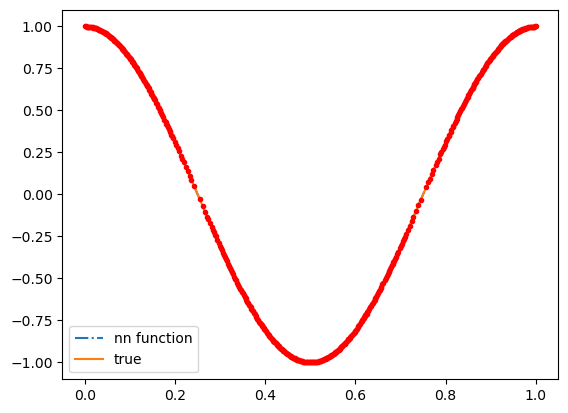

time taken:  165.9649121761322
neuron num 		 error 		 order
4 		 0.140709 		 * 		 1.782486 		 * 

8 		 0.032071 		 2.133376 		 0.878091 		 1.021449 

16 		 0.008514 		 1.913372 		 0.462801 		 0.923978 

32 		 0.002308 		 1.883323 		 0.232917 		 0.990577 

64 		 0.000568 		 2.022245 		 0.115250 		 1.015042 

128 		 0.000139 		 2.028264 		 0.057641 		 0.999605 

256 		 0.000033 		 2.073798 		 0.028894 		 0.996350 

512 		 0.000006 		 2.422078 		 0.014758 		 0.969213 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.140709 &		 * & 		 1.782486 & 		 *  \\ \hline  

8 		 &  3.207e-02 &  		 2.13 &  		 8.781e-01 &  		 1.02 \\ \hline  

16 		 &  8.514e-03 &  		 1.91 &  		 4.628e-01 &  		 0.92 \\ \hline  

32 		 &  2.308e-03 &  		 1.88 &  		 2.329e-01 &  		 0.99 \\ \hline  

64 		 &  5.681e-04 &  		 2.02 &  		 1.153e-01 &  		 1.02 \\ \hline  

128 		 &  1.393e-04 &  		 2.03 &  		 5.764e-02 &  		 1.00 \\ \hline  

256 		 &  3.308e-05 &  		

In [12]:
def u_exact(x):
    return torch.cos(2*pi*x)

def du_exact(x):
    return -2 *pi*torch.sin(2*pi*x)

def rhs(x):
    return  (2*pi)**2 * torch.cos(2*pi*x) + torch.cos(2*pi*x)**3 

def g_N(x):
    return du_exact(x) 

function_name = "sine1d" 
filename_write = "data/1DRandCGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = False 

for N in [2**10]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**17
    order = 3   
    exponent = 9
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, err_h10, my_model = CGARandNonlinearPoissonReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =1, solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)

    

using linear solver:  direct
epoch:  1
torch.Size([2, 4096])
one output
argmax time:  0.08374166488647461
selected neuron index:  tensor(0, device='cuda:0') tensor(1., device='cuda:0') tensor(-0., device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:1.7472065580966756 	 residual l2 norm: 3.144971808606031 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:0.1638449458628798 	 residual l2 norm: 0.4103590013353735 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:0.004408561254250441 	 residual l2 norm: 0.010486289268562446 
newton iteration:  4
torch.Size([1, 1])
sol_update_l2_norm:2.9870249985738413e-06 	 residual l2 norm: 7.095385066838156e-06 
newton iteration:  5
torch.Size([1, 1])
sol_update_l2_norm:1.3676638776992827e-12 	 residual l2 norm: 3.248748492445941e-12 
converged at iteration:  5
sol_update_l2_norm:1.3676638776992827e-12 	 residual l2 norm: 3.248748492445941e-12 
epoch:  2
torch.Size([2, 4096])
two outputs
argmax time:  0.0840401

torch.Size([1, 10])
sol_update_l2_norm:3.164081132473597e-05 	 residual l2 norm: 3.3349388735836886e-06 
newton iteration:  4
torch.Size([1, 10])
sol_update_l2_norm:2.7114546567620195e-10 	 residual l2 norm: 1.2741157886073107e-12 
converged at iteration:  4
sol_update_l2_norm:2.7114546567620195e-10 	 residual l2 norm: 1.2741157886073107e-12 
epoch:  11
torch.Size([2, 4096])
two outputs
argmax time:  0.08416986465454102
selected neuron index:  tensor(1578, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7705078, device='cuda:0')
assembling the matrix time taken:  0.00015115737915039062
solving Ax = b time taken:  0.00022745132446289062
newton iteration:  1
torch.Size([1, 11])
sol_update_l2_norm:1685.2784251459448 	 residual l2 norm: 0.007401370925748559 
newton iteration:  2
torch.Size([1, 11])
sol_update_l2_norm:0.3794619190650721 	 residual l2 norm: 0.021029640877645143 
newton iteration:  3
torch.Size([1, 11])
sol_update_l2_norm:0.0005741876150543259 	 residual l2 norm: 8.229

two outputs
argmax time:  0.08430051803588867
selected neuron index:  tensor(3050, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4895020, device='cuda:0')
assembling the matrix time taken:  0.00015306472778320312
solving Ax = b time taken:  0.0003688335418701172
newton iteration:  1
torch.Size([1, 20])
sol_update_l2_norm:9067.440337400385 	 residual l2 norm: 0.00025958477629401864 
newton iteration:  2
torch.Size([1, 20])
sol_update_l2_norm:0.07353067225806738 	 residual l2 norm: 0.000561800514412834 
newton iteration:  3
torch.Size([1, 20])
sol_update_l2_norm:6.711539387755386e-07 	 residual l2 norm: 5.284589878164302e-08 
converged at iteration:  3
sol_update_l2_norm:6.711539387755386e-07 	 residual l2 norm: 5.284589878164302e-08 
epoch:  21
torch.Size([2, 4096])
two outputs
argmax time:  0.0842599868774414
selected neuron index:  tensor(3901, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9050293, device='cuda:0')
assembling the matrix time taken:  0.000144720077514

torch.Size([1, 31])
sol_update_l2_norm:2.0685454214480793e-06 	 residual l2 norm: 2.0840193232717056e-10 
converged at iteration:  3
sol_update_l2_norm:2.0685454214480793e-06 	 residual l2 norm: 2.0840193232717056e-10 
epoch:  32
torch.Size([2, 4096])
two outputs
argmax time:  0.08435797691345215
selected neuron index:  tensor(1346, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6572266, device='cuda:0')
assembling the matrix time taken:  0.0001690387725830078
solving Ax = b time taken:  0.000545501708984375
newton iteration:  1
torch.Size([1, 32])
sol_update_l2_norm:2412.7576478771393 	 residual l2 norm: 1.4102125441926958e-05 
newton iteration:  2
torch.Size([1, 32])
sol_update_l2_norm:0.0016665530539775918 	 residual l2 norm: 4.466381884527242e-06 
newton iteration:  3
torch.Size([1, 32])
sol_update_l2_norm:2.8643683359145187e-06 	 residual l2 norm: 8.7759474154342e-12 
converged at iteration:  3
sol_update_l2_norm:2.8643683359145187e-06 	 residual l2 norm: 8.7759474154342e-

two outputs
argmax time:  0.08449053764343262
selected neuron index:  tensor(338, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.1650391, device='cuda:0')
assembling the matrix time taken:  0.0001621246337890625
solving Ax = b time taken:  0.0018362998962402344
newton iteration:  1
torch.Size([1, 43])
sol_update_l2_norm:21568.64193755422 	 residual l2 norm: 7.055109451063176e-06 
newton iteration:  2
torch.Size([1, 43])
sol_update_l2_norm:0.05145877878946921 	 residual l2 norm: 5.767841066089845e-06 
newton iteration:  3
torch.Size([1, 43])
sol_update_l2_norm:3.212623887582227e-06 	 residual l2 norm: 3.284189626026478e-12 
converged at iteration:  3
sol_update_l2_norm:3.212623887582227e-06 	 residual l2 norm: 3.284189626026478e-12 
epoch:  44
torch.Size([2, 4096])
two outputs
argmax time:  0.0844728946685791
selected neuron index:  tensor(275, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.1342773, device='cuda:0')
assembling the matrix time taken:  0.000168800354003906

two outputs
argmax time:  0.08460259437561035
selected neuron index:  tensor(1909, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9321289, device='cuda:0')
assembling the matrix time taken:  0.0001785755157470703
solving Ax = b time taken:  0.002022266387939453
newton iteration:  1
torch.Size([1, 55])
sol_update_l2_norm:23398.391235135652 	 residual l2 norm: 1.2244103012278937e-05 
newton iteration:  2
torch.Size([1, 55])
sol_update_l2_norm:2.1591866498689485 	 residual l2 norm: 1.4049697313286154e-09 
newton iteration:  3
torch.Size([1, 55])
sol_update_l2_norm:4.24535985455955e-05 	 residual l2 norm: 1.805891091936672e-11 
converged at iteration:  3
sol_update_l2_norm:4.24535985455955e-05 	 residual l2 norm: 1.805891091936672e-11 
epoch:  56
torch.Size([2, 4096])
two outputs
argmax time:  0.08456754684448242
selected neuron index:  tensor(1152, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5625000, device='cuda:0')
assembling the matrix time taken:  0.0001595020294189

torch.Size([1, 62])
sol_update_l2_norm:0.00018021318851191523 	 residual l2 norm: 1.3069553452362795e-11 
newton iteration:  10
torch.Size([1, 62])
sol_update_l2_norm:0.00016938615125168635 	 residual l2 norm: 7.757300855115419e-12 
newton iteration:  11
torch.Size([1, 62])
sol_update_l2_norm:6.504115748333632e-05 	 residual l2 norm: 1.0604037281681612e-11 
newton iteration:  12
torch.Size([1, 62])
sol_update_l2_norm:0.00010858463741028027 	 residual l2 norm: 2.057189988290585e-12 
newton iteration:  13
torch.Size([1, 62])
sol_update_l2_norm:0.0001157095145200183 	 residual l2 norm: 9.950527916713917e-12 
newton iteration:  14
torch.Size([1, 62])
sol_update_l2_norm:0.0001121080646381349 	 residual l2 norm: 1.1078111812638498e-11 
newton iteration:  15
torch.Size([1, 62])
sol_update_l2_norm:0.00014563170199679852 	 residual l2 norm: 1.9346599689478193e-11 
newton iteration:  16
torch.Size([1, 62])
sol_update_l2_norm:6.370362530737687e-05 	 residual l2 norm: 2.6566087873486777e-12 
newto

torch.Size([1, 66])
sol_update_l2_norm:8.011562684379086e-05 	 residual l2 norm: 1.675750737756209e-11 
newton iteration:  16
torch.Size([1, 66])
sol_update_l2_norm:0.0001237891532221009 	 residual l2 norm: 1.1848027765027526e-11 
newton iteration:  17
torch.Size([1, 66])
sol_update_l2_norm:3.3575342052854346e-05 	 residual l2 norm: 1.7995646008302974e-12 
converged at iteration:  17
sol_update_l2_norm:3.3575342052854346e-05 	 residual l2 norm: 1.7995646008302974e-12 
epoch:  67
torch.Size([2, 4096])
two outputs
argmax time:  0.08461785316467285
selected neuron index:  tensor(3086, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5070801, device='cuda:0')
assembling the matrix time taken:  0.00015878677368164062
solving Ax = b time taken:  0.0013353824615478516
newton iteration:  1
torch.Size([1, 67])
sol_update_l2_norm:112263.77505683237 	 residual l2 norm: 4.1892608765783454e-05 
newton iteration:  2
torch.Size([1, 67])
sol_update_l2_norm:27.806670282409122 	 residual l2 norm: 

torch.Size([1, 69])
sol_update_l2_norm:0.0004094874218429236 	 residual l2 norm: 5.300483751915825e-12 
newton iteration:  20
torch.Size([1, 69])
sol_update_l2_norm:0.00030044290184011457 	 residual l2 norm: 2.1067648271856027e-11 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.00030044290184011457 	 residual l2 norm: 2.1067648271856027e-11 
epoch:  70
torch.Size([2, 4096])
two outputs
argmax time:  0.08461761474609375
selected neuron index:  tensor(903, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4409180, device='cuda:0')
assembling the matrix time taken:  0.00015735626220703125
solving Ax = b time taken:  0.0013725757598876953
newton iteration:  1
torch.Size([1, 70])
sol_update_l2_norm:402152.40447442385 	 residual l2 norm: 4.7027005977075174e-05 
newton iteration:  2
torch.Size([1, 70])
sol_update_l2_norm:105.92202129379734 	 residual l2 norm: 5.521027119543033e-08 
newton iteration:  3
torch.Size([1, 70])
sol_update_l2_norm:0.049231476194688165 	 resid

torch.Size([1, 72])
sol_update_l2_norm:0.00019522782179739857 	 residual l2 norm: 8.360038839542963e-12 
newton iteration:  20
torch.Size([1, 72])
sol_update_l2_norm:0.00016792006387185844 	 residual l2 norm: 7.2698706521234235e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.00016792006387185844 	 residual l2 norm: 7.2698706521234235e-12 
epoch:  73
torch.Size([2, 4096])
two outputs
argmax time:  0.08467459678649902
selected neuron index:  tensor(3173, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5495605, device='cuda:0')
assembling the matrix time taken:  0.00015163421630859375
solving Ax = b time taken:  0.001432657241821289
newton iteration:  1
torch.Size([1, 73])
sol_update_l2_norm:744270.6558118776 	 residual l2 norm: 0.00016994350118677997 
newton iteration:  2
torch.Size([1, 73])
sol_update_l2_norm:364.07973857543556 	 residual l2 norm: 9.942666865242905e-08 
newton iteration:  3
torch.Size([1, 73])
sol_update_l2_norm:0.13350574493573544 	 residu

torch.Size([1, 75])
sol_update_l2_norm:0.00033325749678176064 	 residual l2 norm: 1.1999828612590646e-11 
newton iteration:  17
torch.Size([1, 75])
sol_update_l2_norm:0.0001662124538241552 	 residual l2 norm: 8.628931598332826e-12 
newton iteration:  18
torch.Size([1, 75])
sol_update_l2_norm:0.0004454065834502136 	 residual l2 norm: 1.0803423242146188e-11 
newton iteration:  19
torch.Size([1, 75])
sol_update_l2_norm:0.00042830035255931985 	 residual l2 norm: 1.9696375650306914e-11 
newton iteration:  20
torch.Size([1, 75])
sol_update_l2_norm:0.00022325205329985608 	 residual l2 norm: 7.767990673727297e-12 
Newton solver NOT converged at iteration!!! 
sol_update_l2_norm:0.00022325205329985608 	 residual l2 norm: 7.767990673727297e-12 
epoch:  76
torch.Size([2, 4096])
two outputs
argmax time:  0.08474254608154297
selected neuron index:  tensor(1504, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7343750, device='cuda:0')
assembling the matrix time taken:  0.00016689300537109375
s

torch.Size([1, 78])
sol_update_l2_norm:0.0001836767519219525 	 residual l2 norm: 5.6124045809388975e-12 
newton iteration:  12
torch.Size([1, 78])
sol_update_l2_norm:0.00027378536670446147 	 residual l2 norm: 1.5985736452764238e-11 
newton iteration:  13
torch.Size([1, 78])
sol_update_l2_norm:0.0005327243687183488 	 residual l2 norm: 1.0355671210569637e-11 
newton iteration:  14
torch.Size([1, 78])
sol_update_l2_norm:0.00020016970143362154 	 residual l2 norm: 1.2759833091154645e-11 
newton iteration:  15
torch.Size([1, 78])
sol_update_l2_norm:0.0003914594437303027 	 residual l2 norm: 1.0751605113337639e-11 
newton iteration:  16
torch.Size([1, 78])
sol_update_l2_norm:0.00013574371724062628 	 residual l2 norm: 8.811254659742637e-12 
newton iteration:  17
torch.Size([1, 78])
sol_update_l2_norm:0.0002000623033418458 	 residual l2 norm: 1.2270259734196696e-11 
newton iteration:  18
torch.Size([1, 78])
sol_update_l2_norm:0.00032526892764104756 	 residual l2 norm: 2.9263285735989722e-12 
new

torch.Size([1, 82])
sol_update_l2_norm:0.3404640005790172 	 residual l2 norm: 1.1527077477599084e-11 
newton iteration:  4
torch.Size([1, 82])
sol_update_l2_norm:0.0008457423299478001 	 residual l2 norm: 1.0386611923288275e-11 
newton iteration:  5
torch.Size([1, 82])
sol_update_l2_norm:0.0003511928433772838 	 residual l2 norm: 2.4742370596975694e-11 
newton iteration:  6
torch.Size([1, 82])
sol_update_l2_norm:0.00046794959503739544 	 residual l2 norm: 8.545625799327895e-12 
newton iteration:  7
torch.Size([1, 82])
sol_update_l2_norm:0.00040279980451044005 	 residual l2 norm: 1.0716097330120517e-11 
newton iteration:  8
torch.Size([1, 82])
sol_update_l2_norm:0.0003792314583460957 	 residual l2 norm: 1.0349816741573708e-11 
newton iteration:  9
torch.Size([1, 82])
sol_update_l2_norm:0.0001251764963296619 	 residual l2 norm: 1.1009247755788582e-11 
newton iteration:  10
torch.Size([1, 82])
sol_update_l2_norm:0.0007900523716034147 	 residual l2 norm: 1.4609166541401442e-11 
newton iterati

two outputs
argmax time:  0.08498191833496094
selected neuron index:  tensor(3795, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8532715, device='cuda:0')
assembling the matrix time taken:  0.00016617774963378906
solving Ax = b time taken:  0.0016102790832519531
newton iteration:  1
torch.Size([1, 85])
sol_update_l2_norm:137528.11295281796 	 residual l2 norm: 5.94223080650802e-05 
newton iteration:  2
torch.Size([1, 85])
sol_update_l2_norm:56.26823841549485 	 residual l2 norm: 4.1872608329758656e-08 
newton iteration:  3
torch.Size([1, 85])
sol_update_l2_norm:0.0864045839242882 	 residual l2 norm: 4.259140759547335e-12 
newton iteration:  4
torch.Size([1, 85])
sol_update_l2_norm:0.00016440077826949668 	 residual l2 norm: 5.869074586346499e-12 
newton iteration:  5
torch.Size([1, 85])
sol_update_l2_norm:0.00033010356658197805 	 residual l2 norm: 1.4452649594071463e-11 
newton iteration:  6
torch.Size([1, 85])
sol_update_l2_norm:0.00015291294526621809 	 residual l2 norm: 1.89471

two outputs
argmax time:  0.08481955528259277
selected neuron index:  tensor(2875, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4040527, device='cuda:0')
assembling the matrix time taken:  0.00015878677368164062
solving Ax = b time taken:  0.0016417503356933594
newton iteration:  1
torch.Size([1, 88])
sol_update_l2_norm:133089.2316780306 	 residual l2 norm: 5.635355130339193e-05 
newton iteration:  2
torch.Size([1, 88])
sol_update_l2_norm:187.39877401384396 	 residual l2 norm: 9.546336139673772e-09 
newton iteration:  3
torch.Size([1, 88])
sol_update_l2_norm:0.11112217208632896 	 residual l2 norm: 3.190809870174762e-12 
newton iteration:  4
torch.Size([1, 88])
sol_update_l2_norm:0.00037083279295855556 	 residual l2 norm: 4.139017072090183e-12 
newton iteration:  5
torch.Size([1, 88])
sol_update_l2_norm:0.00027066430245992483 	 residual l2 norm: 1.9388620019818274e-11 
newton iteration:  6
torch.Size([1, 88])
sol_update_l2_norm:0.0003602250160357457 	 residual l2 norm: 2.27681

two outputs
argmax time:  0.08486628532409668
selected neuron index:  tensor(1728, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.8437500, device='cuda:0')
assembling the matrix time taken:  0.00015878677368164062
solving Ax = b time taken:  0.0016889572143554688
newton iteration:  1
torch.Size([1, 91])
sol_update_l2_norm:124278.3502627335 	 residual l2 norm: 0.00011832472038114932 
newton iteration:  2
torch.Size([1, 91])
sol_update_l2_norm:50.04386054661145 	 residual l2 norm: 2.133367034803147e-08 
newton iteration:  3
torch.Size([1, 91])
sol_update_l2_norm:0.04423039782450219 	 residual l2 norm: 1.074066930368726e-11 
newton iteration:  4
torch.Size([1, 91])
sol_update_l2_norm:0.0008061940921734224 	 residual l2 norm: 1.434778285480876e-11 
newton iteration:  5
torch.Size([1, 91])
sol_update_l2_norm:0.00042338200259082874 	 residual l2 norm: 1.399971384083215e-11 
newton iteration:  6
torch.Size([1, 91])
sol_update_l2_norm:0.000416940796389181 	 residual l2 norm: 1.47961446

two outputs
argmax time:  0.08490657806396484
selected neuron index:  tensor(3458, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6887207, device='cuda:0')
assembling the matrix time taken:  0.00015807151794433594
solving Ax = b time taken:  0.0017213821411132812
newton iteration:  1
torch.Size([1, 94])
sol_update_l2_norm:126975.0597956027 	 residual l2 norm: 7.318369885158643e-05 
newton iteration:  2
torch.Size([1, 94])
sol_update_l2_norm:42.404088037758946 	 residual l2 norm: 3.511389138746595e-08 
newton iteration:  3
torch.Size([1, 94])
sol_update_l2_norm:0.03648750014335462 	 residual l2 norm: 5.225811751432615e-12 
newton iteration:  4
torch.Size([1, 94])
sol_update_l2_norm:0.0005856270642694659 	 residual l2 norm: 2.9538280693513636e-12 
newton iteration:  5
torch.Size([1, 94])
sol_update_l2_norm:0.0016460624638070047 	 residual l2 norm: 3.3428458503018022e-12 
newton iteration:  6
torch.Size([1, 94])
sol_update_l2_norm:0.001185876165170133 	 residual l2 norm: 2.3084491

two outputs
argmax time:  0.08502054214477539
selected neuron index:  tensor(3104, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5158691, device='cuda:0')
assembling the matrix time taken:  0.0001690387725830078
solving Ax = b time taken:  0.0017995834350585938
newton iteration:  1
torch.Size([1, 97])
sol_update_l2_norm:440554.93997923017 	 residual l2 norm: 0.0015485953998578138 
newton iteration:  2
torch.Size([1, 97])
sol_update_l2_norm:1843.318728060432 	 residual l2 norm: 4.4315202581126977e-07 
newton iteration:  3
torch.Size([1, 97])
sol_update_l2_norm:3.959851572588536 	 residual l2 norm: 3.052925509321459e-11 
newton iteration:  4
torch.Size([1, 97])
sol_update_l2_norm:0.022587757901937417 	 residual l2 norm: 2.5598198621010318e-11 
newton iteration:  5
torch.Size([1, 97])
sol_update_l2_norm:0.002144151286826504 	 residual l2 norm: 8.410588572831676e-12 
newton iteration:  6
torch.Size([1, 97])
sol_update_l2_norm:0.0018684067269577713 	 residual l2 norm: 1.28185752106

two outputs
argmax time:  0.08501815795898438
selected neuron index:  tensor(1873, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9145508, device='cuda:0')
assembling the matrix time taken:  0.0001595020294189453
solving Ax = b time taken:  0.0018157958984375
newton iteration:  1
torch.Size([1, 100])
sol_update_l2_norm:223902.84107765037 	 residual l2 norm: 0.0005402016209657809 
newton iteration:  2
torch.Size([1, 100])
sol_update_l2_norm:358.2887761927958 	 residual l2 norm: 2.644395549394709e-07 
newton iteration:  3
torch.Size([1, 100])
sol_update_l2_norm:0.7226032730881139 	 residual l2 norm: 1.1839561831296586e-11 
newton iteration:  4
torch.Size([1, 100])
sol_update_l2_norm:0.0035085980363427052 	 residual l2 norm: 2.7631674300629306e-11 
newton iteration:  5
torch.Size([1, 100])
sol_update_l2_norm:0.00033157949542567973 	 residual l2 norm: 1.0262552349772157e-11 
newton iteration:  6
torch.Size([1, 100])
sol_update_l2_norm:0.0003623457211229275 	 residual l2 norm: 4.612

two outputs
argmax time:  0.08499574661254883
selected neuron index:  tensor(1441, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7036133, device='cuda:0')
assembling the matrix time taken:  0.00016546249389648438
solving Ax = b time taken:  0.0018911361694335938
newton iteration:  1
torch.Size([1, 103])
sol_update_l2_norm:777391.4567665759 	 residual l2 norm: 0.000540690420732837 
newton iteration:  2
torch.Size([1, 103])
sol_update_l2_norm:1629.9732830051582 	 residual l2 norm: 9.595331105363272e-07 
newton iteration:  3
torch.Size([1, 103])
sol_update_l2_norm:7.971628860154264 	 residual l2 norm: 2.0864389980213772e-11 
newton iteration:  4
torch.Size([1, 103])
sol_update_l2_norm:0.04669475611484805 	 residual l2 norm: 1.0888194010060634e-11 
newton iteration:  5
torch.Size([1, 103])
sol_update_l2_norm:0.0010526960521577942 	 residual l2 norm: 2.280137635512394e-11 
newton iteration:  6
torch.Size([1, 103])
sol_update_l2_norm:0.0018881128159180186 	 residual l2 norm: 1.71156

two outputs
argmax time:  0.08513021469116211
selected neuron index:  tensor(1285, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6274414, device='cuda:0')
assembling the matrix time taken:  0.00018215179443359375
solving Ax = b time taken:  0.0019083023071289062
newton iteration:  1
torch.Size([1, 106])
sol_update_l2_norm:235697.26249182364 	 residual l2 norm: 0.0005148743733686111 
newton iteration:  2
torch.Size([1, 106])
sol_update_l2_norm:929.0791978443435 	 residual l2 norm: 2.712384895228873e-07 
newton iteration:  3
torch.Size([1, 106])
sol_update_l2_norm:12.795251610467906 	 residual l2 norm: 1.023398843446101e-11 
newton iteration:  4
torch.Size([1, 106])
sol_update_l2_norm:0.1622811836775209 	 residual l2 norm: 1.1137099880090646e-11 
newton iteration:  5
torch.Size([1, 106])
sol_update_l2_norm:0.0042914986665405575 	 residual l2 norm: 1.2624618266189098e-11 
newton iteration:  6
torch.Size([1, 106])
sol_update_l2_norm:0.0013407284980881398 	 residual l2 norm: 7.6985

two outputs
argmax time:  0.08513045310974121
selected neuron index:  tensor(1019, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4975586, device='cuda:0')
assembling the matrix time taken:  0.00016236305236816406
solving Ax = b time taken:  0.001972675323486328
newton iteration:  1
torch.Size([1, 109])
sol_update_l2_norm:479416.9759214757 	 residual l2 norm: 0.0015567184144020987 
newton iteration:  2
torch.Size([1, 109])
sol_update_l2_norm:8703.759346659463 	 residual l2 norm: 8.545008412417481e-07 
newton iteration:  3
torch.Size([1, 109])
sol_update_l2_norm:77.61584881912634 	 residual l2 norm: 1.5379211955798864e-11 
newton iteration:  4
torch.Size([1, 109])
sol_update_l2_norm:1.0122725570928393 	 residual l2 norm: 9.73360013715798e-12 
newton iteration:  5
torch.Size([1, 109])
sol_update_l2_norm:0.019421344558781285 	 residual l2 norm: 1.5889715486994075e-12 
newton iteration:  6
torch.Size([1, 109])
sol_update_l2_norm:0.0013750437325811007 	 residual l2 norm: 5.353478362

two outputs
argmax time:  0.0850517749786377
selected neuron index:  tensor(559, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2729492, device='cuda:0')
assembling the matrix time taken:  0.00016164779663085938
solving Ax = b time taken:  0.001972675323486328
newton iteration:  1
torch.Size([1, 112])
sol_update_l2_norm:801398.1598296759 	 residual l2 norm: 0.002019433521362982 
newton iteration:  2
torch.Size([1, 112])
sol_update_l2_norm:4537.662180740688 	 residual l2 norm: 2.142765078331057e-06 
newton iteration:  3
torch.Size([1, 112])
sol_update_l2_norm:49.89837329951667 	 residual l2 norm: 4.898999605323091e-12 
newton iteration:  4
torch.Size([1, 112])
sol_update_l2_norm:0.8008876857917047 	 residual l2 norm: 1.1179381041373933e-11 
newton iteration:  5
torch.Size([1, 112])
sol_update_l2_norm:0.014247781741887424 	 residual l2 norm: 8.413717753858711e-12 
newton iteration:  6
torch.Size([1, 112])
sol_update_l2_norm:0.0014325515944197292 	 residual l2 norm: 1.349169982663

two outputs
argmax time:  0.08506393432617188
selected neuron index:  tensor(619, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3022461, device='cuda:0')
assembling the matrix time taken:  0.00016069412231445312
solving Ax = b time taken:  0.002229452133178711
newton iteration:  1
torch.Size([1, 115])
sol_update_l2_norm:341771.28380561684 	 residual l2 norm: 0.0014825715906268812 
newton iteration:  2
torch.Size([1, 115])
sol_update_l2_norm:2834.9700564945897 	 residual l2 norm: 5.745320345575238e-07 
newton iteration:  3
torch.Size([1, 115])
sol_update_l2_norm:35.58614773707408 	 residual l2 norm: 4.553793908573305e-12 
newton iteration:  4
torch.Size([1, 115])
sol_update_l2_norm:0.7444437140446831 	 residual l2 norm: 3.2663546328795666e-12 
newton iteration:  5
torch.Size([1, 115])
sol_update_l2_norm:0.014669934626239346 	 residual l2 norm: 1.3756748741859678e-11 
newton iteration:  6
torch.Size([1, 115])
sol_update_l2_norm:0.0028745230059436223 	 residual l2 norm: 8.3397275

two outputs
argmax time:  0.08519840240478516
selected neuron index:  tensor(648, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3164062, device='cuda:0')
assembling the matrix time taken:  0.00016260147094726562
solving Ax = b time taken:  0.0022602081298828125
newton iteration:  1
torch.Size([1, 118])
sol_update_l2_norm:451723.77196945454 	 residual l2 norm: 0.0014334655061524755 
newton iteration:  2
torch.Size([1, 118])
sol_update_l2_norm:7611.172260667786 	 residual l2 norm: 1.1041023601489036e-06 
newton iteration:  3
torch.Size([1, 118])
sol_update_l2_norm:107.33427722193726 	 residual l2 norm: 1.0981451893461221e-11 
newton iteration:  4
torch.Size([1, 118])
sol_update_l2_norm:1.7101917767925783 	 residual l2 norm: 7.308256858296313e-12 
newton iteration:  5
torch.Size([1, 118])
sol_update_l2_norm:0.028058818292025445 	 residual l2 norm: 2.2309100496059363e-11 
newton iteration:  6
torch.Size([1, 118])
sol_update_l2_norm:0.007966200966741747 	 residual l2 norm: 1.564664

two outputs
argmax time:  0.08512473106384277
selected neuron index:  tensor(940, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4589844, device='cuda:0')
assembling the matrix time taken:  0.00016307830810546875
solving Ax = b time taken:  0.0023200511932373047
newton iteration:  1
torch.Size([1, 121])
sol_update_l2_norm:695944.4888251376 	 residual l2 norm: 0.002725436716161773 
newton iteration:  2
torch.Size([1, 121])
sol_update_l2_norm:7170.603834116374 	 residual l2 norm: 1.4357890112780156e-06 
newton iteration:  3
torch.Size([1, 121])
sol_update_l2_norm:108.3544416550518 	 residual l2 norm: 8.372955834453405e-12 
newton iteration:  4
torch.Size([1, 121])
sol_update_l2_norm:2.5297277000278866 	 residual l2 norm: 1.3572805483463983e-11 
newton iteration:  5
torch.Size([1, 121])
sol_update_l2_norm:0.05638014969891377 	 residual l2 norm: 1.5798400347848576e-11 
newton iteration:  6
torch.Size([1, 121])
sol_update_l2_norm:0.001987606254422185 	 residual l2 norm: 9.4271965990

two outputs
argmax time:  0.08512663841247559
selected neuron index:  tensor(2560, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.2502441, device='cuda:0')
assembling the matrix time taken:  0.00017714500427246094
solving Ax = b time taken:  0.0023086071014404297
newton iteration:  1
torch.Size([1, 124])
sol_update_l2_norm:370373.34948469 	 residual l2 norm: 0.0006988668566578383 
newton iteration:  2
torch.Size([1, 124])
sol_update_l2_norm:7334.968836664592 	 residual l2 norm: 4.1750118020476785e-07 
newton iteration:  3
torch.Size([1, 124])
sol_update_l2_norm:99.86178556838067 	 residual l2 norm: 2.3144864980885266e-11 
newton iteration:  4
torch.Size([1, 124])
sol_update_l2_norm:1.9397126410081014 	 residual l2 norm: 1.0279210601344377e-11 
newton iteration:  5
torch.Size([1, 124])
sol_update_l2_norm:0.037771041042706524 	 residual l2 norm: 6.7229254949071654e-12 
newton iteration:  6
torch.Size([1, 124])
sol_update_l2_norm:0.004278997326864265 	 residual l2 norm: 2.68498378

two outputs
argmax time:  0.08514523506164551
selected neuron index:  tensor(912, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4453125, device='cuda:0')
assembling the matrix time taken:  0.0001685619354248047
solving Ax = b time taken:  0.0023937225341796875
newton iteration:  1
torch.Size([1, 127])
sol_update_l2_norm:576410.8833421041 	 residual l2 norm: 0.001416942342112224 
newton iteration:  2
torch.Size([1, 127])
sol_update_l2_norm:2979.3039813688965 	 residual l2 norm: 3.1124921316534135e-07 
newton iteration:  3
torch.Size([1, 127])
sol_update_l2_norm:33.79236024320557 	 residual l2 norm: 1.2853294205275391e-11 
newton iteration:  4
torch.Size([1, 127])
sol_update_l2_norm:0.43460341023236143 	 residual l2 norm: 1.0543356813387528e-11 
newton iteration:  5
torch.Size([1, 127])
sol_update_l2_norm:0.00534955443928115 	 residual l2 norm: 1.0303669000674841e-11 
newton iteration:  6
torch.Size([1, 127])
sol_update_l2_norm:0.0025732950510875636 	 residual l2 norm: 1.9365827

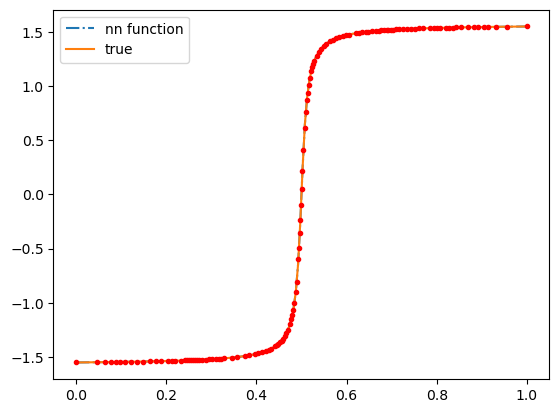

time taken:  22.334330081939697
neuron num 		 error 		 order
4 		 0.461772 		 * 		 11.542355 		 * 

8 		 0.207748 		 1.152347 		 9.707613 		 0.249749 

16 		 0.070152 		 1.566281 		 6.244719 		 0.636480 

32 		 0.005996 		 3.548418 		 1.303211 		 2.260566 

64 		 0.000035 		 7.418425 		 0.024486 		 5.733984 

128 		 0.000002 		 3.989534 		 0.003738 		 2.711634 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.461772 &		 * & 		 11.542355 & 		 *  \\ \hline  

8 		 &  2.077e-01 &  		 1.15 &  		 9.708e+00 &  		 0.25 \\ \hline  

16 		 &  7.015e-02 &  		 1.57 &  		 6.245e+00 &  		 0.64 \\ \hline  

32 		 &  5.996e-03 &  		 3.55 &  		 1.303e+00 &  		 2.26 \\ \hline  

64 		 &  3.505e-05 &  		 7.42 &  		 2.449e-02 &  		 5.73 \\ \hline  

128 		 &  2.207e-06 &  		 3.99 &  		 3.738e-03 &  		 2.71 \\ \hline  



In [30]:
# def u_exact(x):
#     return torch.cos(2*pi*x)

# def du_exact(x):
#     return -2 *pi*torch.sin(2*pi*x)

# def rhs(x):
#     return  (2*pi)**2 * torch.cos(2*pi*x) + torch.cos(2*pi*x)**3 

# def g_N(x):
#     return du_exact(x) 

alpha = 100 
def u_exact(x):
    return torch.arctan(alpha * (x-0.5))

def du_exact(x):
    return alpha/(1+(alpha*(x-0.5))**2)
def laplace_u_exact(x):
    return -2*alpha**3*(x-0.5)/(1+(alpha*(x-0.5))**2)**2

def rhs(x):
    return  -laplace_u_exact(x) + u_exact(x)**3 

def g_N(x):
    return du_exact(x) 


function_name = "sine1d" 
filename_write = "data/1DOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = False 
relu_k = 3
for N in [2**11]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**14
    order = 5 
    exponent = 7
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, err_h10, my_model = CGANonlinearPoissonReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =relu_k, solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)

    

#### arctan example 

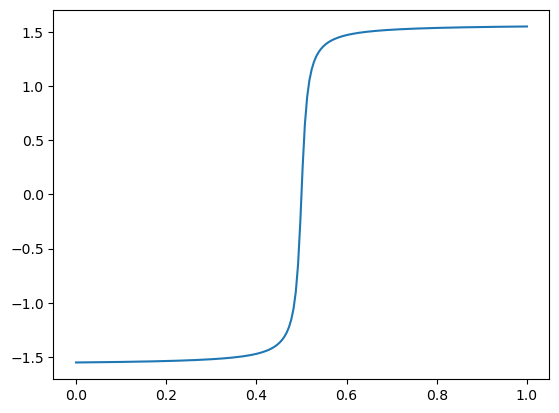

In [17]:
## arctan example 
alpha = 100 
def u_exact(x):
    return torch.arctan(alpha * (x-0.5))

# plot the exact solution
x_test = torch.linspace(0,1,200).view(-1,1).to(device)
u_true = u_exact(x_test)
plt.plot(x_test.cpu(),u_true.cpu().detach())
plt.show()


using linear solver:  direct
epoch:  1
torch.Size([2, 16384])
one output
argmax time:  0.14299702644348145
selected neuron index:  tensor(0, device='cuda:0') tensor(1., device='cuda:0') tensor(-0., device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:4.001251345329126 	 residual l2 norm: 4.001251369336635 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:1.2080320850825819 	 residual l2 norm: 12.81297727436752 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:0.5546022223485523 	 residual l2 norm: 3.151016613710655 
newton iteration:  4
torch.Size([1, 1])
sol_update_l2_norm:0.1201339517484136 	 residual l2 norm: 0.4813902459659054 
newton iteration:  5
torch.Size([1, 1])
sol_update_l2_norm:0.005155368221228975 	 residual l2 norm: 0.01903896340246526 
newton iteration:  6
torch.Size([1, 1])
sol_update_l2_norm:9.173229682381633e-06 	 residual l2 norm: 3.3756990164293676e-05 
newton iteration:  7
torch.Size([1, 1])
sol_update_l2_norm:2.8997767272

two outputs
argmax time:  0.14241957664489746
selected neuron index:  tensor(10974, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3396606, device='cuda:0')
assembling the matrix time taken:  0.00017333030700683594
solving Ax = b time taken:  0.0001621246337890625
newton iteration:  1
torch.Size([1, 11])
sol_update_l2_norm:1.5068703925967315 	 residual l2 norm: 0.10514695294380295 
newton iteration:  2
torch.Size([1, 11])
sol_update_l2_norm:0.0014573424600003836 	 residual l2 norm: 0.002294146768674618 
newton iteration:  3
torch.Size([1, 11])
sol_update_l2_norm:1.7175301580446374e-07 	 residual l2 norm: 4.990371355509779e-07 
newton iteration:  4
torch.Size([1, 11])
sol_update_l2_norm:7.473126497408792e-13 	 residual l2 norm: 2.914607448109338e-14 
converged at iteration:  4
sol_update_l2_norm:7.473126497408792e-13 	 residual l2 norm: 2.914607448109338e-14 
epoch:  12
torch.Size([2, 16384])
two outputs
argmax time:  0.14225554466247559
selected neuron index:  tensor(4227, devi

two outputs
argmax time:  0.14250850677490234
selected neuron index:  tensor(12454, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5203247, device='cuda:0')
assembling the matrix time taken:  0.0001747608184814453
solving Ax = b time taken:  0.00026535987854003906
newton iteration:  1
torch.Size([1, 23])
sol_update_l2_norm:10.247087531548912 	 residual l2 norm: 0.017284239661414992 
newton iteration:  2
torch.Size([1, 23])
sol_update_l2_norm:2.715500172471326e-06 	 residual l2 norm: 2.2829247963573174e-06 
newton iteration:  3
torch.Size([1, 23])
sol_update_l2_norm:6.984778528269899e-12 	 residual l2 norm: 5.872414695163175e-13 
converged at iteration:  3
sol_update_l2_norm:6.984778528269899e-12 	 residual l2 norm: 5.872414695163175e-13 
epoch:  24
torch.Size([2, 16384])
two outputs
argmax time:  0.1424393653869629
selected neuron index:  tensor(11760, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4356079, device='cuda:0')
assembling the matrix time taken:  0.000226497

two outputs
argmax time:  0.14255809783935547
selected neuron index:  tensor(4060, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4956055, device='cuda:0')
assembling the matrix time taken:  0.00018644332885742188
solving Ax = b time taken:  0.000392913818359375
newton iteration:  1
torch.Size([1, 35])
sol_update_l2_norm:12.778789518595975 	 residual l2 norm: 0.007146637148353359 
newton iteration:  2
torch.Size([1, 35])
sol_update_l2_norm:5.55271130314869e-08 	 residual l2 norm: 4.6530609679629934e-08 
newton iteration:  3
torch.Size([1, 35])
sol_update_l2_norm:5.449297108973024e-11 	 residual l2 norm: 2.158860250457583e-14 
converged at iteration:  3
sol_update_l2_norm:5.449297108973024e-11 	 residual l2 norm: 2.158860250457583e-14 
epoch:  36
torch.Size([2, 16384])
two outputs
argmax time:  0.14249634742736816
selected neuron index:  tensor(4183, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5106201, device='cuda:0')
assembling the matrix time taken:  0.000218391418

two outputs
argmax time:  0.1424260139465332
selected neuron index:  tensor(2345, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2862549, device='cuda:0')
assembling the matrix time taken:  0.0001933574676513672
solving Ax = b time taken:  0.0016207695007324219
newton iteration:  1
torch.Size([1, 47])
sol_update_l2_norm:0.1818530450049417 	 residual l2 norm: 0.003911477295243203 
newton iteration:  2
torch.Size([1, 47])
sol_update_l2_norm:1.7520605627431958e-06 	 residual l2 norm: 3.114216285018384e-06 
newton iteration:  3
torch.Size([1, 47])
sol_update_l2_norm:2.0987232144610834e-11 	 residual l2 norm: 7.302231881669896e-13 
converged at iteration:  3
sol_update_l2_norm:2.0987232144610834e-11 	 residual l2 norm: 7.302231881669896e-13 
epoch:  48
torch.Size([2, 16384])
two outputs
argmax time:  0.14255523681640625
selected neuron index:  tensor(12523, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5287476, device='cuda:0')
assembling the matrix time taken:  0.000234842

two outputs
argmax time:  0.1429443359375
selected neuron index:  tensor(3952, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4824219, device='cuda:0')
assembling the matrix time taken:  0.00023937225341796875
solving Ax = b time taken:  0.0017261505126953125
newton iteration:  1
torch.Size([1, 59])
sol_update_l2_norm:4.173810166071804 	 residual l2 norm: 0.002287915681877218 
newton iteration:  2
torch.Size([1, 59])
sol_update_l2_norm:1.3656870664692713e-08 	 residual l2 norm: 1.3922261432178677e-08 
newton iteration:  3
torch.Size([1, 59])
sol_update_l2_norm:4.666854340687151e-11 	 residual l2 norm: 1.4656698461606785e-14 
converged at iteration:  3
sol_update_l2_norm:4.666854340687151e-11 	 residual l2 norm: 1.4656698461606785e-14 
epoch:  60
torch.Size([2, 16384])
two outputs
argmax time:  0.14326095581054688
selected neuron index:  tensor(3262, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3981934, device='cuda:0')
assembling the matrix time taken:  0.000199556350

two outputs
argmax time:  0.1434783935546875
selected neuron index:  tensor(12056, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4717407, device='cuda:0')
assembling the matrix time taken:  0.00018286705017089844
solving Ax = b time taken:  0.0008721351623535156
newton iteration:  1
torch.Size([1, 71])
sol_update_l2_norm:1.8320664897219867 	 residual l2 norm: 0.0015962520046685822 
newton iteration:  2
torch.Size([1, 71])
sol_update_l2_norm:1.128633546982055e-08 	 residual l2 norm: 1.2264950226930747e-08 
newton iteration:  3
torch.Size([1, 71])
sol_update_l2_norm:9.368150635905909e-11 	 residual l2 norm: 2.1340762602560758e-14 
converged at iteration:  3
sol_update_l2_norm:9.368150635905909e-11 	 residual l2 norm: 2.1340762602560758e-14 
epoch:  72
torch.Size([2, 16384])
two outputs
argmax time:  0.14253830909729004
selected neuron index:  tensor(4190, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5114746, device='cuda:0')
assembling the matrix time taken:  0.0002312

two outputs
argmax time:  0.14304089546203613
selected neuron index:  tensor(12347, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5072632, device='cuda:0')
assembling the matrix time taken:  0.0002143383026123047
solving Ax = b time taken:  0.0009984970092773438
newton iteration:  1
torch.Size([1, 83])
sol_update_l2_norm:4.65019200640482 	 residual l2 norm: 0.0011587108489238337 
newton iteration:  2
torch.Size([1, 83])
sol_update_l2_norm:8.795531781666906e-10 	 residual l2 norm: 9.286552697136975e-10 
converged at iteration:  2
sol_update_l2_norm:8.795531781666906e-10 	 residual l2 norm: 9.286552697136975e-10 
epoch:  84
torch.Size([2, 16384])
two outputs
argmax time:  0.14256048202514648
selected neuron index:  tensor(12427, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5170288, device='cuda:0')
assembling the matrix time taken:  0.00020122528076171875
solving Ax = b time taken:  0.0009815692901611328
newton iteration:  1
torch.Size([1, 84])
sol_update_l2_norm:2.820

two outputs
argmax time:  0.14289641380310059
selected neuron index:  tensor(14255, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7401733, device='cuda:0')
assembling the matrix time taken:  0.00020503997802734375
solving Ax = b time taken:  0.0010974407196044922
newton iteration:  1
torch.Size([1, 95])
sol_update_l2_norm:0.06543836597378347 	 residual l2 norm: 0.0009397656618567972 
newton iteration:  2
torch.Size([1, 95])
sol_update_l2_norm:6.607336260720707e-08 	 residual l2 norm: 1.5878170033179506e-07 
newton iteration:  3
torch.Size([1, 95])
sol_update_l2_norm:1.169693956358374e-10 	 residual l2 norm: 3.3146195089627776e-14 
converged at iteration:  3
sol_update_l2_norm:1.169693956358374e-10 	 residual l2 norm: 3.3146195089627776e-14 
epoch:  96
torch.Size([2, 16384])
two outputs
argmax time:  0.14260411262512207
selected neuron index:  tensor(12485, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5241089, device='cuda:0')
assembling the matrix time taken:  0.0001

two outputs
argmax time:  0.14295458793640137
selected neuron index:  tensor(4449, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5430908, device='cuda:0')
assembling the matrix time taken:  0.00019049644470214844
solving Ax = b time taken:  0.0012445449829101562
newton iteration:  1
torch.Size([1, 107])
sol_update_l2_norm:0.7316830864307399 	 residual l2 norm: 0.0006904329764057034 
newton iteration:  2
torch.Size([1, 107])
sol_update_l2_norm:2.609039189048464e-09 	 residual l2 norm: 3.0242629579841973e-09 
newton iteration:  3
torch.Size([1, 107])
sol_update_l2_norm:3.8806147419706866e-11 	 residual l2 norm: 2.8874655174239364e-14 
converged at iteration:  3
sol_update_l2_norm:3.8806147419706866e-11 	 residual l2 norm: 2.8874655174239364e-14 
epoch:  108
torch.Size([2, 16384])
two outputs
argmax time:  0.14369893074035645
selected neuron index:  tensor(12235, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4935913, device='cuda:0')
assembling the matrix time taken:  0.

two outputs
argmax time:  0.14355111122131348
selected neuron index:  tensor(3969, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4844971, device='cuda:0')
assembling the matrix time taken:  0.0002307891845703125
solving Ax = b time taken:  0.0014891624450683594
newton iteration:  1
torch.Size([1, 119])
sol_update_l2_norm:2.115169897374694 	 residual l2 norm: 0.0005471956366153864 
newton iteration:  2
torch.Size([1, 119])
sol_update_l2_norm:4.408802375778005e-10 	 residual l2 norm: 3.831683521096227e-10 
converged at iteration:  2
sol_update_l2_norm:4.408802375778005e-10 	 residual l2 norm: 3.831683521096227e-10 
epoch:  120
torch.Size([2, 16384])
two outputs
argmax time:  0.14285945892333984
selected neuron index:  tensor(12181, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4869995, device='cuda:0')
assembling the matrix time taken:  0.00023126602172851562
solving Ax = b time taken:  0.0014674663543701172
newton iteration:  1
torch.Size([1, 120])
sol_update_l2_norm:2

torch.Size([1, 131])
sol_update_l2_norm:1.65643953795213e-10 	 residual l2 norm: 4.774095933300896e-14 
converged at iteration:  3
sol_update_l2_norm:1.65643953795213e-10 	 residual l2 norm: 4.774095933300896e-14 
epoch:  132
torch.Size([2, 16384])
two outputs
argmax time:  0.14295101165771484
selected neuron index:  tensor(12839, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5673218, device='cuda:0')
assembling the matrix time taken:  0.00026917457580566406
solving Ax = b time taken:  0.0017998218536376953
newton iteration:  1
torch.Size([1, 132])
sol_update_l2_norm:0.29441113508228806 	 residual l2 norm: 0.0004452209906343674 
newton iteration:  2
torch.Size([1, 132])
sol_update_l2_norm:1.6978038365688693e-09 	 residual l2 norm: 2.6203618697248864e-09 
converged at iteration:  2
sol_update_l2_norm:1.6978038365688693e-09 	 residual l2 norm: 2.6203618697248864e-09 
epoch:  133
torch.Size([2, 16384])
two outputs
argmax time:  0.14316225051879883
selected neuron index:  tensor(3

torch.Size([2, 16384])
two outputs
argmax time:  0.14286518096923828
selected neuron index:  tensor(12047, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4706421, device='cuda:0')
assembling the matrix time taken:  0.00018334388732910156
solving Ax = b time taken:  0.001967906951904297
newton iteration:  1
torch.Size([1, 144])
sol_update_l2_norm:0.8547480308335026 	 residual l2 norm: 0.00038336762660046804 
newton iteration:  2
torch.Size([1, 144])
sol_update_l2_norm:4.1571621976604825e-10 	 residual l2 norm: 4.921883138122229e-10 
converged at iteration:  2
sol_update_l2_norm:4.1571621976604825e-10 	 residual l2 norm: 4.921883138122229e-10 
epoch:  145
torch.Size([2, 16384])
two outputs
argmax time:  0.14315032958984375
selected neuron index:  tensor(11069, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3512573, device='cuda:0')
assembling the matrix time taken:  0.00023412704467773438
solving Ax = b time taken:  0.001987934112548828
newton iteration:  1
torch.Size([1,

two outputs
argmax time:  0.14313364028930664
selected neuron index:  tensor(4223, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5155029, device='cuda:0')
assembling the matrix time taken:  0.00021457672119140625
solving Ax = b time taken:  0.0021173954010009766
newton iteration:  1
torch.Size([1, 157])
sol_update_l2_norm:1.6012859481906254 	 residual l2 norm: 0.00031918984912131953 
newton iteration:  2
torch.Size([1, 157])
sol_update_l2_norm:8.395972860353837e-11 	 residual l2 norm: 1.1764717256300533e-10 
converged at iteration:  2
sol_update_l2_norm:8.395972860353837e-11 	 residual l2 norm: 1.1764717256300533e-10 
epoch:  158
torch.Size([2, 16384])
two outputs
argmax time:  0.14307522773742676
selected neuron index:  tensor(4215, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5145264, device='cuda:0')
assembling the matrix time taken:  0.0002562999725341797
solving Ax = b time taken:  0.002096891403198242
newton iteration:  1
torch.Size([1, 158])
sol_update_l2_norm

two outputs
argmax time:  0.14293241500854492
selected neuron index:  tensor(3749, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4576416, device='cuda:0')
assembling the matrix time taken:  0.0001811981201171875
solving Ax = b time taken:  0.002292156219482422
newton iteration:  1
torch.Size([1, 169])
sol_update_l2_norm:0.46150535727753916 	 residual l2 norm: 0.0002905711219366778 
newton iteration:  2
torch.Size([1, 169])
sol_update_l2_norm:3.0430856042529667e-10 	 residual l2 norm: 4.452451370544966e-10 
converged at iteration:  2
sol_update_l2_norm:3.0430856042529667e-10 	 residual l2 norm: 4.452451370544966e-10 
epoch:  170
torch.Size([2, 16384])
two outputs
argmax time:  0.14310741424560547
selected neuron index:  tensor(13143, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6044312, device='cuda:0')
assembling the matrix time taken:  0.00023651123046875
solving Ax = b time taken:  0.002249002456665039
newton iteration:  1
torch.Size([1, 170])
sol_update_l2_norm:0.

torch.Size([1, 181])
sol_update_l2_norm:8.903249944194368e-11 	 residual l2 norm: 7.996089743422817e-11 
converged at iteration:  2
sol_update_l2_norm:8.903249944194368e-11 	 residual l2 norm: 7.996089743422817e-11 
epoch:  182
torch.Size([2, 16384])
two outputs
argmax time:  0.14322209358215332
selected neuron index:  tensor(14113, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7228394, device='cuda:0')
assembling the matrix time taken:  0.0002422332763671875
solving Ax = b time taken:  0.0023643970489501953
newton iteration:  1
torch.Size([1, 182])
sol_update_l2_norm:0.03690243256086301 	 residual l2 norm: 0.00025158760738566764 
newton iteration:  2
torch.Size([1, 182])
sol_update_l2_norm:2.487214431448854e-09 	 residual l2 norm: 7.200619023720735e-09 
newton iteration:  3
torch.Size([1, 182])
sol_update_l2_norm:7.72729677308204e-11 	 residual l2 norm: 2.453248388418248e-14 
converged at iteration:  3
sol_update_l2_norm:7.72729677308204e-11 	 residual l2 norm: 2.453248388418

two outputs
argmax time:  0.14350676536560059
selected neuron index:  tensor(6216, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7587891, device='cuda:0')
assembling the matrix time taken:  0.00024056434631347656
solving Ax = b time taken:  0.002841472625732422
newton iteration:  1
torch.Size([1, 195])
sol_update_l2_norm:0.027933441471101723 	 residual l2 norm: 0.00021824866682393777 
newton iteration:  2
torch.Size([1, 195])
sol_update_l2_norm:1.956629718085241e-09 	 residual l2 norm: 7.2987790170884864e-09 
newton iteration:  3
torch.Size([1, 195])
sol_update_l2_norm:1.4488490641196096e-10 	 residual l2 norm: 2.5209707050357355e-14 
converged at iteration:  3
sol_update_l2_norm:1.4488490641196096e-10 	 residual l2 norm: 2.5209707050357355e-14 
epoch:  196
torch.Size([2, 16384])
two outputs
argmax time:  0.1432030200958252
selected neuron index:  tensor(4369, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5333252, device='cuda:0')
assembling the matrix time taken:  0.

two outputs
argmax time:  0.1436784267425537
selected neuron index:  tensor(11649, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4220581, device='cuda:0')
assembling the matrix time taken:  0.00025177001953125
solving Ax = b time taken:  0.0028531551361083984
newton iteration:  1
torch.Size([1, 208])
sol_update_l2_norm:0.14992570165220803 	 residual l2 norm: 0.00017907792276630817 
newton iteration:  2
torch.Size([1, 208])
sol_update_l2_norm:2.157381062152552e-10 	 residual l2 norm: 4.2956851022422295e-10 
converged at iteration:  2
sol_update_l2_norm:2.157381062152552e-10 	 residual l2 norm: 4.2956851022422295e-10 
epoch:  209
torch.Size([2, 16384])
two outputs
argmax time:  0.14323711395263672
selected neuron index:  tensor(4031, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4920654, device='cuda:0')
assembling the matrix time taken:  0.0002384185791015625
solving Ax = b time taken:  0.0029358863830566406
newton iteration:  1
torch.Size([1, 209])
sol_update_l2_norm:

torch.Size([1, 221])
sol_update_l2_norm:0.1119764590169988 	 residual l2 norm: 0.00015582683385381295 
newton iteration:  2
torch.Size([1, 221])
sol_update_l2_norm:3.787645991272839e-10 	 residual l2 norm: 4.0339153513576397e-10 
converged at iteration:  2
sol_update_l2_norm:3.787645991272839e-10 	 residual l2 norm: 4.0339153513576397e-10 
epoch:  222
torch.Size([2, 16384])
two outputs
argmax time:  0.14318346977233887
selected neuron index:  tensor(6938, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.8469238, device='cuda:0')
assembling the matrix time taken:  0.0001926422119140625
solving Ax = b time taken:  0.003081083297729492
newton iteration:  1
torch.Size([1, 222])
sol_update_l2_norm:0.01673798503044733 	 residual l2 norm: 0.00015535233436989732 
newton iteration:  2
torch.Size([1, 222])
sol_update_l2_norm:1.1972448965154458e-09 	 residual l2 norm: 6.375896750346819e-09 
converged at iteration:  2
sol_update_l2_norm:1.1972448965154458e-09 	 residual l2 norm: 6.3758967503

torch.Size([1, 234])
sol_update_l2_norm:2.4074021518334806e-10 	 residual l2 norm: 4.6887602955489946e-11 
converged at iteration:  2
sol_update_l2_norm:2.4074021518334806e-10 	 residual l2 norm: 4.6887602955489946e-11 
epoch:  235
torch.Size([2, 16384])
two outputs
argmax time:  0.1433553695678711
selected neuron index:  tensor(4525, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5523682, device='cuda:0')
assembling the matrix time taken:  0.00025534629821777344
solving Ax = b time taken:  0.003194093704223633
newton iteration:  1
torch.Size([1, 235])
sol_update_l2_norm:0.24036872879340282 	 residual l2 norm: 0.0001421031585632674 
newton iteration:  2
torch.Size([1, 235])
sol_update_l2_norm:1.122132447504394e-10 	 residual l2 norm: 1.2023107937021072e-10 
converged at iteration:  2
sol_update_l2_norm:1.122132447504394e-10 	 residual l2 norm: 1.2023107937021072e-10 
epoch:  236
torch.Size([2, 16384])
two outputs
argmax time:  0.14446187019348145
selected neuron index:  tensor(

two outputs
argmax time:  0.14381003379821777
selected neuron index:  tensor(12114, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4788208, device='cuda:0')
assembling the matrix time taken:  0.00030231475830078125
solving Ax = b time taken:  0.0032563209533691406
newton iteration:  1
torch.Size([1, 248])
sol_update_l2_norm:0.7420916227282253 	 residual l2 norm: 0.0001290282785550404 
newton iteration:  2
torch.Size([1, 248])
sol_update_l2_norm:4.3071209641618966e-11 	 residual l2 norm: 2.961685407024842e-11 
converged at iteration:  2
sol_update_l2_norm:4.3071209641618966e-11 	 residual l2 norm: 2.961685407024842e-11 
epoch:  249
torch.Size([2, 16384])
two outputs
argmax time:  0.14345693588256836
selected neuron index:  tensor(12768, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5586548, device='cuda:0')
assembling the matrix time taken:  0.0002391338348388672
solving Ax = b time taken:  0.0033550262451171875
newton iteration:  1
torch.Size([1, 249])
sol_update_l2_no

two outputs
argmax time:  0.14342498779296875
selected neuron index:  tensor(12262, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4968872, device='cuda:0')
assembling the matrix time taken:  0.0002110004425048828
solving Ax = b time taken:  0.004392862319946289
newton iteration:  1
torch.Size([1, 261])
sol_update_l2_norm:1.351441721340229 	 residual l2 norm: 0.00011577625661771332 
newton iteration:  2
torch.Size([1, 261])
sol_update_l2_norm:1.7750329415108463e-10 	 residual l2 norm: 1.954677906697542e-11 
converged at iteration:  2
sol_update_l2_norm:1.7750329415108463e-10 	 residual l2 norm: 1.954677906697542e-11 
epoch:  262
torch.Size([2, 16384])
two outputs
argmax time:  0.1433722972869873
selected neuron index:  tensor(4016, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4902344, device='cuda:0')
assembling the matrix time taken:  0.0002269744873046875
solving Ax = b time taken:  0.004362583160400391
newton iteration:  1
torch.Size([1, 262])
sol_update_l2_norm:1.

solving Ax = b time taken:  0.004526853561401367
newton iteration:  1
torch.Size([1, 274])
sol_update_l2_norm:1.402021958894409 	 residual l2 norm: 0.00010745396495710549 
newton iteration:  2
torch.Size([1, 274])
sol_update_l2_norm:1.0034443644382888e-10 	 residual l2 norm: 4.9020614427560936e-11 
converged at iteration:  2
sol_update_l2_norm:1.0034443644382888e-10 	 residual l2 norm: 4.9020614427560936e-11 
epoch:  275
torch.Size([2, 16384])
two outputs
argmax time:  0.1436305046081543
selected neuron index:  tensor(12077, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4743042, device='cuda:0')
assembling the matrix time taken:  0.00032830238342285156
solving Ax = b time taken:  0.0045299530029296875
newton iteration:  1
torch.Size([1, 275])
sol_update_l2_norm:0.5318488585033192 	 residual l2 norm: 0.00010603352148024358 
newton iteration:  2
torch.Size([1, 275])
sol_update_l2_norm:8.18081097742721e-11 	 residual l2 norm: 1.93070097231942e-11 
converged at iteration:  2
sol_u

torch.Size([1, 287])
sol_update_l2_norm:1.26531765429279 	 residual l2 norm: 9.643726863235212e-05 
newton iteration:  2
torch.Size([1, 287])
sol_update_l2_norm:3.644659862516775e-10 	 residual l2 norm: 3.441865973901917e-11 
converged at iteration:  2
sol_update_l2_norm:3.644659862516775e-10 	 residual l2 norm: 3.441865973901917e-11 
epoch:  288
torch.Size([2, 16384])
two outputs
argmax time:  0.1434166431427002
selected neuron index:  tensor(3833, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4678955, device='cuda:0')
assembling the matrix time taken:  0.000186920166015625
solving Ax = b time taken:  0.0047261714935302734
newton iteration:  1
torch.Size([1, 288])
sol_update_l2_norm:0.3931205937348921 	 residual l2 norm: 9.592924483394386e-05 
newton iteration:  2
torch.Size([1, 288])
sol_update_l2_norm:6.528433791883351e-11 	 residual l2 norm: 2.1043392902062807e-11 
converged at iteration:  2
sol_update_l2_norm:6.528433791883351e-11 	 residual l2 norm: 2.1043392902062807e-1

torch.Size([1, 300])
sol_update_l2_norm:3.1054767678699396e-10 	 residual l2 norm: 1.2687897739893488e-11 
converged at iteration:  2
sol_update_l2_norm:3.1054767678699396e-10 	 residual l2 norm: 1.2687897739893488e-11 
epoch:  301
torch.Size([2, 16384])
two outputs
argmax time:  0.14352703094482422
selected neuron index:  tensor(12390, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5125122, device='cuda:0')
assembling the matrix time taken:  0.00017714500427246094
solving Ax = b time taken:  0.004968404769897461
newton iteration:  1
torch.Size([1, 301])
sol_update_l2_norm:0.9950595897827935 	 residual l2 norm: 8.525506217156637e-05 
newton iteration:  2
torch.Size([1, 301])
sol_update_l2_norm:1.2260931279213583e-10 	 residual l2 norm: 7.710251709424288e-12 
converged at iteration:  2
sol_update_l2_norm:1.2260931279213583e-10 	 residual l2 norm: 7.710251709424288e-12 
epoch:  302
torch.Size([2, 16384])
two outputs
argmax time:  0.14356422424316406
selected neuron index:  tensor

two outputs
argmax time:  0.14353394508361816
selected neuron index:  tensor(4225, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5157471, device='cuda:0')
assembling the matrix time taken:  0.0001761913299560547
solving Ax = b time taken:  0.0050258636474609375
newton iteration:  1
torch.Size([1, 314])
sol_update_l2_norm:0.7774137953068703 	 residual l2 norm: 7.769779215094763e-05 
newton iteration:  2
torch.Size([1, 314])
sol_update_l2_norm:1.9326984098566437e-10 	 residual l2 norm: 4.296265580807147e-12 
converged at iteration:  2
sol_update_l2_norm:1.9326984098566437e-10 	 residual l2 norm: 4.296265580807147e-12 
epoch:  315
torch.Size([2, 16384])
two outputs
argmax time:  0.14351153373718262
selected neuron index:  tensor(10926, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3338013, device='cuda:0')
assembling the matrix time taken:  0.0001983642578125
solving Ax = b time taken:  0.005017518997192383
newton iteration:  1
torch.Size([1, 315])
sol_update_l2_norm:0.0

torch.Size([1, 326])
sol_update_l2_norm:4.926942538346532e-10 	 residual l2 norm: 3.553603286848469e-12 
converged at iteration:  2
sol_update_l2_norm:4.926942538346532e-10 	 residual l2 norm: 3.553603286848469e-12 
epoch:  327
torch.Size([2, 16384])
two outputs
argmax time:  0.14435887336730957
selected neuron index:  tensor(4145, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5059814, device='cuda:0')
assembling the matrix time taken:  0.00017762184143066406
solving Ax = b time taken:  0.005503416061401367
newton iteration:  1
torch.Size([1, 327])
sol_update_l2_norm:1.2214264468840865 	 residual l2 norm: 7.301932210156334e-05 
newton iteration:  2
torch.Size([1, 327])
sol_update_l2_norm:6.645797589323899e-10 	 residual l2 norm: 3.556535187053312e-12 
converged at iteration:  2
sol_update_l2_norm:6.645797589323899e-10 	 residual l2 norm: 3.556535187053312e-12 
epoch:  328
torch.Size([2, 16384])
two outputs
argmax time:  0.14364385604858398
selected neuron index:  tensor(12401,

two outputs
argmax time:  0.14415335655212402
selected neuron index:  tensor(4077, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4976807, device='cuda:0')
assembling the matrix time taken:  0.0001850128173828125
solving Ax = b time taken:  0.0058596134185791016
newton iteration:  1
torch.Size([1, 339])
sol_update_l2_norm:0.9303185606089981 	 residual l2 norm: 7.05561815500138e-05 
newton iteration:  2
torch.Size([1, 339])
sol_update_l2_norm:5.427732421630417e-10 	 residual l2 norm: 9.695322725916711e-12 
converged at iteration:  2
sol_update_l2_norm:5.427732421630417e-10 	 residual l2 norm: 9.695322725916711e-12 
epoch:  340
torch.Size([2, 16384])
two outputs
argmax time:  0.14378738403320312
selected neuron index:  tensor(4265, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5206299, device='cuda:0')
assembling the matrix time taken:  0.00018739700317382812
solving Ax = b time taken:  0.005785703659057617
newton iteration:  1
torch.Size([1, 340])
sol_update_l2_norm:0.5

selected neuron index:  tensor(10716, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3081665, device='cuda:0')
assembling the matrix time taken:  0.00020170211791992188
solving Ax = b time taken:  0.005911827087402344
newton iteration:  1
torch.Size([1, 352])
sol_update_l2_norm:0.025258308114312775 	 residual l2 norm: 6.655108281627163e-05 
newton iteration:  2
torch.Size([1, 352])
sol_update_l2_norm:5.10739741901159e-10 	 residual l2 norm: 2.709578498491485e-10 
converged at iteration:  2
sol_update_l2_norm:5.10739741901159e-10 	 residual l2 norm: 2.709578498491485e-10 
epoch:  353
torch.Size([2, 16384])
two outputs
argmax time:  0.1436769962310791
selected neuron index:  tensor(5854, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7145996, device='cuda:0')
assembling the matrix time taken:  0.00019311904907226562
solving Ax = b time taken:  0.005995273590087891
newton iteration:  1
torch.Size([1, 353])
sol_update_l2_norm:0.021454838645738706 	 residual l2 norm: 6.60390

selected neuron index:  tensor(11790, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4392700, device='cuda:0')
assembling the matrix time taken:  0.00020623207092285156
solving Ax = b time taken:  0.00610661506652832
newton iteration:  1
torch.Size([1, 365])
sol_update_l2_norm:0.12940433528249665 	 residual l2 norm: 6.325611137139802e-05 
newton iteration:  2
torch.Size([1, 365])
sol_update_l2_norm:2.8142654112425516e-10 	 residual l2 norm: 2.3763432514839434e-11 
converged at iteration:  2
sol_update_l2_norm:2.8142654112425516e-10 	 residual l2 norm: 2.3763432514839434e-11 
epoch:  366
torch.Size([2, 16384])
two outputs
argmax time:  0.14374947547912598
selected neuron index:  tensor(4342, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5300293, device='cuda:0')
assembling the matrix time taken:  0.00018334388732910156
solving Ax = b time taken:  0.006103515625
newton iteration:  1
torch.Size([1, 366])
sol_update_l2_norm:0.33640366031296376 	 residual l2 norm: 6.2499523

selected neuron index:  tensor(4335, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5291748, device='cuda:0')
assembling the matrix time taken:  0.0002465248107910156
solving Ax = b time taken:  0.006211042404174805
newton iteration:  1
torch.Size([1, 378])
sol_update_l2_norm:0.3325463982175255 	 residual l2 norm: 5.8951636655781864e-05 
newton iteration:  2
torch.Size([1, 378])
sol_update_l2_norm:3.8551317900053395e-10 	 residual l2 norm: 6.176278212037751e-12 
converged at iteration:  2
sol_update_l2_norm:3.8551317900053395e-10 	 residual l2 norm: 6.176278212037751e-12 
epoch:  379
torch.Size([2, 16384])
two outputs
argmax time:  0.1440417766571045
selected neuron index:  tensor(12437, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5182495, device='cuda:0')
assembling the matrix time taken:  0.00030231475830078125
solving Ax = b time taken:  0.006197214126586914
newton iteration:  1
torch.Size([1, 379])
sol_update_l2_norm:0.5817753448670402 	 residual l2 norm: 5.80111

two outputs
argmax time:  0.14508295059204102
selected neuron index:  tensor(2145, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2618408, device='cuda:0')
assembling the matrix time taken:  0.00022363662719726562
solving Ax = b time taken:  0.007311344146728516
newton iteration:  1
torch.Size([1, 391])
sol_update_l2_norm:0.01692881827346205 	 residual l2 norm: 5.365923038496863e-05 
newton iteration:  2
torch.Size([1, 391])
sol_update_l2_norm:3.6207601715265766e-10 	 residual l2 norm: 2.800359619594871e-10 
converged at iteration:  2
sol_update_l2_norm:3.6207601715265766e-10 	 residual l2 norm: 2.800359619594871e-10 
epoch:  392
torch.Size([2, 16384])
two outputs
argmax time:  0.14414191246032715
selected neuron index:  tensor(12494, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5252075, device='cuda:0')
assembling the matrix time taken:  0.00021505355834960938
solving Ax = b time taken:  0.00724482536315918
newton iteration:  1
torch.Size([1, 392])
sol_update_l2_norm

two outputs
argmax time:  0.1443631649017334
selected neuron index:  tensor(12572, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5347290, device='cuda:0')
assembling the matrix time taken:  0.0002484321594238281
solving Ax = b time taken:  0.007356882095336914
newton iteration:  1
torch.Size([1, 404])
sol_update_l2_norm:0.24779356037482733 	 residual l2 norm: 4.846437599928546e-05 
newton iteration:  2
torch.Size([1, 404])
sol_update_l2_norm:1.7280497560976854e-10 	 residual l2 norm: 5.296023965884335e-12 
converged at iteration:  2
sol_update_l2_norm:1.7280497560976854e-10 	 residual l2 norm: 5.296023965884335e-12 
epoch:  405
torch.Size([2, 16384])
two outputs
argmax time:  0.1442716121673584
selected neuron index:  tensor(12238, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4939575, device='cuda:0')
assembling the matrix time taken:  0.00027298927307128906
solving Ax = b time taken:  0.007447957992553711
newton iteration:  1
torch.Size([1, 405])
sol_update_l2_norm:

two outputs
argmax time:  0.14400386810302734
selected neuron index:  tensor(3445, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4205322, device='cuda:0')
assembling the matrix time taken:  0.0001838207244873047
solving Ax = b time taken:  0.007653713226318359
newton iteration:  1
torch.Size([1, 417])
sol_update_l2_norm:0.07358201395056409 	 residual l2 norm: 4.4980265669324925e-05 
newton iteration:  2
torch.Size([1, 417])
sol_update_l2_norm:7.937186049217254e-10 	 residual l2 norm: 1.8921456270186645e-11 
converged at iteration:  2
sol_update_l2_norm:7.937186049217254e-10 	 residual l2 norm: 1.8921456270186645e-11 
epoch:  418
torch.Size([2, 16384])
two outputs
argmax time:  0.14528417587280273
selected neuron index:  tensor(4032, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4921875, device='cuda:0')
assembling the matrix time taken:  0.00026226043701171875
solving Ax = b time taken:  0.0075724124908447266
newton iteration:  1
torch.Size([1, 418])
sol_update_l2_nor

two outputs
argmax time:  0.14406275749206543
selected neuron index:  tensor(12136, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4815063, device='cuda:0')
assembling the matrix time taken:  0.0001881122589111328
solving Ax = b time taken:  0.007760286331176758
newton iteration:  1
torch.Size([1, 430])
sol_update_l2_norm:0.49846747414911763 	 residual l2 norm: 4.27132235223517e-05 
newton iteration:  2
torch.Size([1, 430])
sol_update_l2_norm:9.860555419459203e-10 	 residual l2 norm: 1.4428936478309321e-12 
converged at iteration:  2
sol_update_l2_norm:9.860555419459203e-10 	 residual l2 norm: 1.4428936478309321e-12 
epoch:  431
torch.Size([2, 16384])
two outputs
argmax time:  0.14449143409729004
selected neuron index:  tensor(6645, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.8111572, device='cuda:0')
assembling the matrix time taken:  0.00025081634521484375
solving Ax = b time taken:  0.007735252380371094
newton iteration:  1
torch.Size([1, 431])
sol_update_l2_norm:

two outputs
argmax time:  0.14441752433776855
selected neuron index:  tensor(15028, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8345337, device='cuda:0')
assembling the matrix time taken:  0.00024199485778808594
solving Ax = b time taken:  0.007900714874267578
newton iteration:  1
torch.Size([1, 443])
sol_update_l2_norm:0.014348480902601756 	 residual l2 norm: 3.992771416574811e-05 
newton iteration:  2
torch.Size([1, 443])
sol_update_l2_norm:7.497798204153398e-10 	 residual l2 norm: 2.912905507791121e-10 
converged at iteration:  2
sol_update_l2_norm:7.497798204153398e-10 	 residual l2 norm: 2.912905507791121e-10 
epoch:  444
torch.Size([2, 16384])
two outputs
argmax time:  0.14743757247924805
selected neuron index:  tensor(3988, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4868164, device='cuda:0')
assembling the matrix time taken:  0.0002758502960205078
solving Ax = b time taken:  0.007783651351928711
newton iteration:  1
torch.Size([1, 444])
sol_update_l2_norm:

two outputs
argmax time:  0.14418244361877441
selected neuron index:  tensor(12148, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4829712, device='cuda:0')
assembling the matrix time taken:  0.0001800060272216797
solving Ax = b time taken:  0.008350372314453125
newton iteration:  1
torch.Size([1, 456])
sol_update_l2_norm:0.4977517425652895 	 residual l2 norm: 3.752723765645896e-05 
newton iteration:  2
torch.Size([1, 456])
sol_update_l2_norm:4.537398332867612e-10 	 residual l2 norm: 1.7398759811034452e-12 
converged at iteration:  2
sol_update_l2_norm:4.537398332867612e-10 	 residual l2 norm: 1.7398759811034452e-12 
epoch:  457
torch.Size([2, 16384])
two outputs
argmax time:  0.14451360702514648
selected neuron index:  tensor(3309, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4039307, device='cuda:0')
assembling the matrix time taken:  0.00022721290588378906
solving Ax = b time taken:  0.008437633514404297
newton iteration:  1
torch.Size([1, 457])
sol_update_l2_norm:

two outputs
argmax time:  0.14423298835754395
selected neuron index:  tensor(3981, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4859619, device='cuda:0')
assembling the matrix time taken:  0.00019049644470214844
solving Ax = b time taken:  0.008607625961303711
newton iteration:  1
torch.Size([1, 469])
sol_update_l2_norm:0.6010868484646105 	 residual l2 norm: 3.563803885006978e-05 
newton iteration:  2
torch.Size([1, 469])
sol_update_l2_norm:2.9996723466749825e-10 	 residual l2 norm: 7.077680450353148e-13 
converged at iteration:  2
sol_update_l2_norm:2.9996723466749825e-10 	 residual l2 norm: 7.077680450353148e-13 
epoch:  470
torch.Size([2, 16384])
two outputs
argmax time:  0.14474153518676758
selected neuron index:  tensor(12201, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4894409, device='cuda:0')
assembling the matrix time taken:  0.0002741813659667969
solving Ax = b time taken:  0.008529186248779297
newton iteration:  1
torch.Size([1, 470])
sol_update_l2_norm:

two outputs
argmax time:  0.14539265632629395
selected neuron index:  tensor(12711, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5516968, device='cuda:0')
assembling the matrix time taken:  0.000244140625
solving Ax = b time taken:  0.008620977401733398
newton iteration:  1
torch.Size([1, 482])
sol_update_l2_norm:0.1169474122082583 	 residual l2 norm: 3.3364926268246e-05 
newton iteration:  2
torch.Size([1, 482])
sol_update_l2_norm:8.626813188884608e-10 	 residual l2 norm: 4.480905974355625e-12 
converged at iteration:  2
sol_update_l2_norm:8.626813188884608e-10 	 residual l2 norm: 4.480905974355625e-12 
epoch:  483
torch.Size([2, 16384])
two outputs
argmax time:  0.1446385383605957
selected neuron index:  tensor(12761, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5578003, device='cuda:0')
assembling the matrix time taken:  0.00022459030151367188
solving Ax = b time taken:  0.008711099624633789
newton iteration:  1
torch.Size([1, 483])
sol_update_l2_norm:0.099903887

two outputs
argmax time:  0.14465641975402832
selected neuron index:  tensor(3921, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4786377, device='cuda:0')
assembling the matrix time taken:  0.00026297569274902344
solving Ax = b time taken:  0.008767843246459961
newton iteration:  1
torch.Size([1, 495])
sol_update_l2_norm:0.36350991974070107 	 residual l2 norm: 3.1123706634250076e-05 
newton iteration:  2
torch.Size([1, 495])
sol_update_l2_norm:4.681255364840555e-10 	 residual l2 norm: 9.1806288585401e-13 
converged at iteration:  2
sol_update_l2_norm:4.681255364840555e-10 	 residual l2 norm: 9.1806288585401e-13 
epoch:  496
torch.Size([2, 16384])
two outputs
argmax time:  0.14461040496826172
selected neuron index:  tensor(12748, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5562134, device='cuda:0')
assembling the matrix time taken:  0.00020766258239746094
solving Ax = b time taken:  0.00872182846069336
newton iteration:  1
torch.Size([1, 496])
sol_update_l2_norm:0.09

two outputs
argmax time:  0.14491677284240723
selected neuron index:  tensor(12817, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5646362, device='cuda:0')
assembling the matrix time taken:  0.0002453327178955078
solving Ax = b time taken:  0.008948564529418945
newton iteration:  1
torch.Size([1, 507])
sol_update_l2_norm:0.08114751715282505 	 residual l2 norm: 2.9947769846021783e-05 
newton iteration:  2
torch.Size([1, 507])
sol_update_l2_norm:1.300021041599527e-10 	 residual l2 norm: 5.33380689286938e-12 
converged at iteration:  2
sol_update_l2_norm:1.300021041599527e-10 	 residual l2 norm: 5.33380689286938e-12 
epoch:  508
torch.Size([2, 16384])
two outputs
argmax time:  0.14549922943115234
selected neuron index:  tensor(3997, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4879150, device='cuda:0')
assembling the matrix time taken:  0.00020051002502441406
solving Ax = b time taken:  0.008870124816894531
newton iteration:  1
torch.Size([1, 508])
sol_update_l2_norm:0.

two outputs
argmax time:  0.14504647254943848
selected neuron index:  tensor(16236, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9819946, device='cuda:0')
assembling the matrix time taken:  0.000232696533203125
solving Ax = b time taken:  0.010269641876220703
newton iteration:  1
torch.Size([1, 520])
sol_update_l2_norm:0.016437472451894412 	 residual l2 norm: 2.7923956094621995e-05 
newton iteration:  2
torch.Size([1, 520])
sol_update_l2_norm:1.1296239394311451e-10 	 residual l2 norm: 2.989246605997235e-10 
converged at iteration:  2
sol_update_l2_norm:1.1296239394311451e-10 	 residual l2 norm: 2.989246605997235e-10 
epoch:  521
torch.Size([2, 16384])
two outputs
argmax time:  0.1447124481201172
selected neuron index:  tensor(11260, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3745728, device='cuda:0')
assembling the matrix time taken:  0.00019216537475585938
solving Ax = b time taken:  0.010465860366821289
newton iteration:  1
torch.Size([1, 521])
sol_update_l2_nor

two outputs
argmax time:  0.14501357078552246
selected neuron index:  tensor(12290, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5003052, device='cuda:0')
assembling the matrix time taken:  0.000278472900390625
solving Ax = b time taken:  0.010652542114257812
newton iteration:  1
torch.Size([1, 533])
sol_update_l2_norm:0.18901903938710699 	 residual l2 norm: 2.6618019416828115e-05 
newton iteration:  2
torch.Size([1, 533])
sol_update_l2_norm:3.8049822852416503e-10 	 residual l2 norm: 7.689330485505422e-14 
converged at iteration:  2
sol_update_l2_norm:3.8049822852416503e-10 	 residual l2 norm: 7.689330485505422e-14 
epoch:  534
torch.Size([2, 16384])
two outputs
argmax time:  0.14499449729919434
selected neuron index:  tensor(4203, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5130615, device='cuda:0')
assembling the matrix time taken:  0.0003008842468261719
solving Ax = b time taken:  0.010581016540527344
newton iteration:  1
torch.Size([1, 534])
sol_update_l2_norm:

two outputs
argmax time:  0.14571881294250488
selected neuron index:  tensor(3840, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4687500, device='cuda:0')
assembling the matrix time taken:  0.0002052783966064453
solving Ax = b time taken:  0.010782957077026367
newton iteration:  1
torch.Size([1, 546])
sol_update_l2_norm:0.2014309564624653 	 residual l2 norm: 2.5011040731919843e-05 
newton iteration:  2
torch.Size([1, 546])
sol_update_l2_norm:4.869591826293893e-10 	 residual l2 norm: 1.1008625583858154e-12 
converged at iteration:  2
sol_update_l2_norm:4.869591826293893e-10 	 residual l2 norm: 1.1008625583858154e-12 
epoch:  547
torch.Size([2, 16384])
two outputs
argmax time:  0.14458727836608887
selected neuron index:  tensor(4721, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5762939, device='cuda:0')
assembling the matrix time taken:  0.00018405914306640625
solving Ax = b time taken:  0.010840654373168945
newton iteration:  1
torch.Size([1, 547])
sol_update_l2_norm:

two outputs
argmax time:  0.14464354515075684
selected neuron index:  tensor(12339, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5062866, device='cuda:0')
assembling the matrix time taken:  0.0001819133758544922
solving Ax = b time taken:  0.010975122451782227
newton iteration:  1
torch.Size([1, 559])
sol_update_l2_norm:0.7296763081894095 	 residual l2 norm: 2.4283477709135624e-05 
newton iteration:  2
torch.Size([1, 559])
sol_update_l2_norm:7.335851965390304e-10 	 residual l2 norm: 1.3111766803042908e-12 
converged at iteration:  2
sol_update_l2_norm:7.335851965390304e-10 	 residual l2 norm: 1.3111766803042908e-12 
epoch:  560
torch.Size([2, 16384])
two outputs
argmax time:  0.14460277557373047
selected neuron index:  tensor(4139, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5052490, device='cuda:0')
assembling the matrix time taken:  0.00018286705017089844
solving Ax = b time taken:  0.010813474655151367
newton iteration:  1
torch.Size([1, 560])
sol_update_l2_norm

two outputs
argmax time:  0.14605712890625
selected neuron index:  tensor(12346, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5071411, device='cuda:0')
assembling the matrix time taken:  0.0002307891845703125
solving Ax = b time taken:  0.010972023010253906
newton iteration:  1
torch.Size([1, 572])
sol_update_l2_norm:0.7127518081864329 	 residual l2 norm: 2.374835652695051e-05 
newton iteration:  2
torch.Size([1, 572])
sol_update_l2_norm:2.596533954556522e-10 	 residual l2 norm: 1.0764620911121657e-12 
converged at iteration:  2
sol_update_l2_norm:2.596533954556522e-10 	 residual l2 norm: 1.0764620911121657e-12 
epoch:  573
torch.Size([2, 16384])
two outputs
argmax time:  0.14490294456481934
selected neuron index:  tensor(3899, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4759521, device='cuda:0')
assembling the matrix time taken:  0.00019288063049316406
solving Ax = b time taken:  0.011157751083374023
newton iteration:  1
torch.Size([1, 573])
sol_update_l2_norm:0.2

two outputs
argmax time:  0.1449112892150879
selected neuron index:  tensor(4159, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5076904, device='cuda:0')
assembling the matrix time taken:  0.00018930435180664062
solving Ax = b time taken:  0.012065410614013672
newton iteration:  1
torch.Size([1, 585])
sol_update_l2_norm:0.6910761096578967 	 residual l2 norm: 2.314132944396121e-05 
newton iteration:  2
torch.Size([1, 585])
sol_update_l2_norm:5.963135776975345e-10 	 residual l2 norm: 8.660932690298813e-13 
converged at iteration:  2
sol_update_l2_norm:5.963135776975345e-10 	 residual l2 norm: 8.660932690298813e-13 
epoch:  586
torch.Size([2, 16384])
two outputs
argmax time:  0.14529776573181152
selected neuron index:  tensor(4062, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4958496, device='cuda:0')
assembling the matrix time taken:  0.00023937225341796875
solving Ax = b time taken:  0.012033224105834961
newton iteration:  1
torch.Size([1, 586])
sol_update_l2_norm:0.6

two outputs
argmax time:  0.14495372772216797
selected neuron index:  tensor(4165, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5084229, device='cuda:0')
assembling the matrix time taken:  0.00019049644470214844
solving Ax = b time taken:  0.012229681015014648
newton iteration:  1
torch.Size([1, 598])
sol_update_l2_norm:0.6567349242587636 	 residual l2 norm: 2.162485110040006e-05 
newton iteration:  2
torch.Size([1, 598])
sol_update_l2_norm:2.341897985387416e-10 	 residual l2 norm: 7.235129938865021e-13 
converged at iteration:  2
sol_update_l2_norm:2.341897985387416e-10 	 residual l2 norm: 7.235129938865021e-13 
epoch:  599
torch.Size([2, 16384])
two outputs
argmax time:  0.14602994918823242
selected neuron index:  tensor(4065, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4962158, device='cuda:0')
assembling the matrix time taken:  0.00021719932556152344
solving Ax = b time taken:  0.012242555618286133
newton iteration:  1
torch.Size([1, 599])
sol_update_l2_norm:0.

two outputs
argmax time:  0.14519000053405762
selected neuron index:  tensor(4220, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5151367, device='cuda:0')
assembling the matrix time taken:  0.0002167224884033203
solving Ax = b time taken:  0.012429475784301758
newton iteration:  1
torch.Size([1, 611])
sol_update_l2_norm:0.4181402863111953 	 residual l2 norm: 2.1248777662903674e-05 
newton iteration:  2
torch.Size([1, 611])
sol_update_l2_norm:6.876841318541441e-10 	 residual l2 norm: 2.592892856317012e-13 
converged at iteration:  2
sol_update_l2_norm:6.876841318541441e-10 	 residual l2 norm: 2.592892856317012e-13 
epoch:  612
torch.Size([2, 16384])
two outputs
argmax time:  0.1448054313659668
selected neuron index:  tensor(12440, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5186157, device='cuda:0')
assembling the matrix time taken:  0.00026345252990722656
solving Ax = b time taken:  0.012295961380004883
newton iteration:  1
torch.Size([1, 612])
sol_update_l2_norm:0.

two outputs
argmax time:  0.14509081840515137
selected neuron index:  tensor(12365, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5094604, device='cuda:0')
assembling the matrix time taken:  0.00018978118896484375
solving Ax = b time taken:  0.012427568435668945
newton iteration:  1
torch.Size([1, 624])
sol_update_l2_norm:0.6018818967383067 	 residual l2 norm: 1.975916200345071e-05 
newton iteration:  2
torch.Size([1, 624])
sol_update_l2_norm:4.903553187101346e-10 	 residual l2 norm: 5.107337213617113e-13 
converged at iteration:  2
sol_update_l2_norm:4.903553187101346e-10 	 residual l2 norm: 5.107337213617113e-13 
epoch:  625
torch.Size([2, 16384])
two outputs
argmax time:  0.14536046981811523
selected neuron index:  tensor(12261, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4967651, device='cuda:0')
assembling the matrix time taken:  0.000240325927734375
solving Ax = b time taken:  0.01292872428894043
newton iteration:  1
torch.Size([1, 625])
sol_update_l2_norm:0.6

two outputs
argmax time:  0.145003080368042
selected neuron index:  tensor(13086, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5974731, device='cuda:0')
assembling the matrix time taken:  0.0001888275146484375
solving Ax = b time taken:  0.013075113296508789
newton iteration:  1
torch.Size([1, 637])
sol_update_l2_norm:0.05764962237259379 	 residual l2 norm: 1.907434156051206e-05 
newton iteration:  2
torch.Size([1, 637])
sol_update_l2_norm:1.765792377789277e-10 	 residual l2 norm: 4.067883068185249e-12 
converged at iteration:  2
sol_update_l2_norm:1.765792377789277e-10 	 residual l2 norm: 4.067883068185249e-12 
epoch:  638
torch.Size([2, 16384])
two outputs
argmax time:  0.14533567428588867
selected neuron index:  tensor(4176, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5097656, device='cuda:0')
assembling the matrix time taken:  0.0002238750457763672
solving Ax = b time taken:  0.013027191162109375
newton iteration:  1
torch.Size([1, 638])
sol_update_l2_norm:0.56

two outputs
argmax time:  0.1452016830444336
selected neuron index:  tensor(3788, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4624023, device='cuda:0')
assembling the matrix time taken:  0.00020742416381835938
solving Ax = b time taken:  0.01498866081237793
newton iteration:  1
torch.Size([1, 650])
sol_update_l2_norm:0.14575129049863014 	 residual l2 norm: 1.9660314192647968e-05 
newton iteration:  2
torch.Size([1, 650])
sol_update_l2_norm:2.2406203604556058e-10 	 residual l2 norm: 7.122494691165904e-13 
converged at iteration:  2
sol_update_l2_norm:2.2406203604556058e-10 	 residual l2 norm: 7.122494691165904e-13 
epoch:  651
torch.Size([2, 16384])
two outputs
argmax time:  0.1452934741973877
selected neuron index:  tensor(12311, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5028687, device='cuda:0')
assembling the matrix time taken:  0.00020647048950195312
solving Ax = b time taken:  0.015135526657104492
newton iteration:  1
torch.Size([1, 651])
sol_update_l2_norm:

two outputs
argmax time:  0.14587926864624023
selected neuron index:  tensor(4182, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5104980, device='cuda:0')
assembling the matrix time taken:  0.00018358230590820312
solving Ax = b time taken:  0.015293598175048828
newton iteration:  1
torch.Size([1, 663])
sol_update_l2_norm:0.5312841256042056 	 residual l2 norm: 1.848273843019568e-05 
newton iteration:  2
torch.Size([1, 663])
sol_update_l2_norm:2.0470059275917397e-10 	 residual l2 norm: 3.3425469328866546e-13 
converged at iteration:  2
sol_update_l2_norm:2.0470059275917397e-10 	 residual l2 norm: 3.3425469328866546e-13 
epoch:  664
torch.Size([2, 16384])
two outputs
argmax time:  0.1455085277557373
selected neuron index:  tensor(13888, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6953735, device='cuda:0')
assembling the matrix time taken:  0.00023031234741210938
solving Ax = b time taken:  0.015080690383911133
newton iteration:  1
torch.Size([1, 664])
sol_update_l2_nor

two outputs
argmax time:  0.14544034004211426
selected neuron index:  tensor(12511, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5272827, device='cuda:0')
assembling the matrix time taken:  0.00024199485778808594
solving Ax = b time taken:  0.015238046646118164
newton iteration:  1
torch.Size([1, 676])
sol_update_l2_norm:0.20504905407176982 	 residual l2 norm: 1.7314972106545214e-05 
newton iteration:  2
torch.Size([1, 676])
sol_update_l2_norm:2.0792803176378053e-10 	 residual l2 norm: 3.813164249085515e-13 
converged at iteration:  2
sol_update_l2_norm:2.0792803176378053e-10 	 residual l2 norm: 3.813164249085515e-13 
epoch:  677
torch.Size([2, 16384])
two outputs
argmax time:  0.14536094665527344
selected neuron index:  tensor(13179, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.6088257, device='cuda:0')
assembling the matrix time taken:  0.00024080276489257812
solving Ax = b time taken:  0.015435934066772461
newton iteration:  1
torch.Size([1, 677])
sol_update_l2_n

two outputs
argmax time:  0.1451737880706787
selected neuron index:  tensor(4187, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5111084, device='cuda:0')
assembling the matrix time taken:  0.0001926422119140625
solving Ax = b time taken:  0.015622854232788086
newton iteration:  1
torch.Size([1, 689])
sol_update_l2_norm:0.5147149674332337 	 residual l2 norm: 1.927651208880222e-05 
newton iteration:  2
torch.Size([1, 689])
sol_update_l2_norm:3.4265364122755654e-10 	 residual l2 norm: 3.0846805609495537e-13 
converged at iteration:  2
sol_update_l2_norm:3.4265364122755654e-10 	 residual l2 norm: 3.0846805609495537e-13 
epoch:  690
torch.Size([2, 16384])
two outputs
argmax time:  0.1462852954864502
selected neuron index:  tensor(14013, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7106323, device='cuda:0')
assembling the matrix time taken:  0.00023484230041503906
solving Ax = b time taken:  0.01555490493774414
newton iteration:  1
torch.Size([1, 690])
sol_update_l2_norm:0

two outputs
argmax time:  0.14553022384643555
selected neuron index:  tensor(4076, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4975586, device='cuda:0')
assembling the matrix time taken:  0.00019598007202148438
solving Ax = b time taken:  0.015736103057861328
newton iteration:  1
torch.Size([1, 701])
sol_update_l2_norm:0.48754097909708044 	 residual l2 norm: 1.6260111073681316e-05 
newton iteration:  2
torch.Size([1, 701])
sol_update_l2_norm:4.997492838761586e-10 	 residual l2 norm: 1.9229315575606062e-13 
converged at iteration:  2
sol_update_l2_norm:4.997492838761586e-10 	 residual l2 norm: 1.9229315575606062e-13 
epoch:  702
torch.Size([2, 16384])
two outputs
argmax time:  0.14579248428344727
selected neuron index:  tensor(12543, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5311890, device='cuda:0')
assembling the matrix time taken:  0.00023245811462402344
solving Ax = b time taken:  0.01566290855407715
newton iteration:  1
torch.Size([1, 702])
sol_update_l2_nor

two outputs
argmax time:  0.14535760879516602
selected neuron index:  tensor(12432, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5176392, device='cuda:0')
assembling the matrix time taken:  0.0001819133758544922
solving Ax = b time taken:  0.016881227493286133
newton iteration:  1
torch.Size([1, 714])
sol_update_l2_norm:0.31589046854494457 	 residual l2 norm: 1.6471453194214895e-05 
newton iteration:  2
torch.Size([1, 714])
sol_update_l2_norm:8.954858811539707e-10 	 residual l2 norm: 1.834103467587983e-13 
converged at iteration:  2
sol_update_l2_norm:8.954858811539707e-10 	 residual l2 norm: 1.834103467587983e-13 
epoch:  715
torch.Size([2, 16384])
two outputs
argmax time:  0.14581847190856934
selected neuron index:  tensor(11918, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4548950, device='cuda:0')
assembling the matrix time taken:  0.0002849102020263672
solving Ax = b time taken:  0.01688098907470703
newton iteration:  1
torch.Size([1, 715])
sol_update_l2_norm:0

two outputs
argmax time:  0.14670920372009277
selected neuron index:  tensor(4383, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5350342, device='cuda:0')
assembling the matrix time taken:  0.00022149085998535156
solving Ax = b time taken:  0.017070531845092773
newton iteration:  1
torch.Size([1, 727])
sol_update_l2_norm:0.1417368431538821 	 residual l2 norm: 1.5142923238990148e-05 
newton iteration:  2
torch.Size([1, 727])
sol_update_l2_norm:3.232092975698142e-10 	 residual l2 norm: 3.886572928308661e-13 
converged at iteration:  2
sol_update_l2_norm:3.232092975698142e-10 	 residual l2 norm: 3.886572928308661e-13 
epoch:  728
torch.Size([2, 16384])
two outputs
argmax time:  0.1454451084136963
selected neuron index:  tensor(10505, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.2824097, device='cuda:0')
assembling the matrix time taken:  0.0001850128173828125
solving Ax = b time taken:  0.016977548599243164
newton iteration:  1
torch.Size([1, 728])
sol_update_l2_norm:0.

two outputs
argmax time:  0.14546728134155273
selected neuron index:  tensor(5091, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6214600, device='cuda:0')
assembling the matrix time taken:  0.00018548965454101562
solving Ax = b time taken:  0.017184019088745117
newton iteration:  1
torch.Size([1, 740])
sol_update_l2_norm:0.05145761047806568 	 residual l2 norm: 1.5135976650252277e-05 
newton iteration:  2
torch.Size([1, 740])
sol_update_l2_norm:3.2177802677515326e-10 	 residual l2 norm: 3.279149077885244e-12 
converged at iteration:  2
sol_update_l2_norm:3.2177802677515326e-10 	 residual l2 norm: 3.279149077885244e-12 
epoch:  741
torch.Size([2, 16384])
two outputs
argmax time:  0.14577651023864746
selected neuron index:  tensor(5118, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6247559, device='cuda:0')
assembling the matrix time taken:  0.00023508071899414062
solving Ax = b time taken:  0.017304182052612305
newton iteration:  1
torch.Size([1, 741])
sol_update_l2_nor

two outputs
argmax time:  0.1458578109741211
selected neuron index:  tensor(14368, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7539673, device='cuda:0')
assembling the matrix time taken:  0.0002467632293701172
solving Ax = b time taken:  0.01747870445251465
newton iteration:  1
torch.Size([1, 753])
sol_update_l2_norm:0.050777221827906616 	 residual l2 norm: 1.4148388256775696e-05 
newton iteration:  2
torch.Size([1, 753])
sol_update_l2_norm:2.4474419120048777e-10 	 residual l2 norm: 1.4324362170147504e-11 
converged at iteration:  2
sol_update_l2_norm:2.4474419120048777e-10 	 residual l2 norm: 1.4324362170147504e-11 
epoch:  754
torch.Size([2, 16384])
two outputs
argmax time:  0.14650845527648926
selected neuron index:  tensor(12532, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5298462, device='cuda:0')
assembling the matrix time taken:  0.0001895427703857422
solving Ax = b time taken:  0.017488956451416016
newton iteration:  1
torch.Size([1, 754])
sol_update_l2_no

two outputs
argmax time:  0.14554238319396973
selected neuron index:  tensor(5266, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6428223, device='cuda:0')
assembling the matrix time taken:  0.000213623046875
solving Ax = b time taken:  0.017595291137695312
newton iteration:  1
torch.Size([1, 766])
sol_update_l2_norm:0.05370185870927 	 residual l2 norm: 1.3557845885142319e-05 
newton iteration:  2
torch.Size([1, 766])
sol_update_l2_norm:1.1104246558738604e-09 	 residual l2 norm: 3.57681619607833e-12 
newton iteration:  3
torch.Size([1, 766])
sol_update_l2_norm:3.4026033552721237e-10 	 residual l2 norm: 7.155410420285754e-14 
converged at iteration:  3
sol_update_l2_norm:3.4026033552721237e-10 	 residual l2 norm: 7.155410420285754e-14 
epoch:  767
torch.Size([2, 16384])
two outputs
argmax time:  0.14557814598083496
selected neuron index:  tensor(11702, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4285278, device='cuda:0')
assembling the matrix time taken:  0.0002133846

two outputs
argmax time:  0.1460587978363037
selected neuron index:  tensor(3487, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4256592, device='cuda:0')
assembling the matrix time taken:  0.00022792816162109375
solving Ax = b time taken:  0.019170761108398438
newton iteration:  1
torch.Size([1, 778])
sol_update_l2_norm:0.06573023905074386 	 residual l2 norm: 1.2967645082337495e-05 
newton iteration:  2
torch.Size([1, 778])
sol_update_l2_norm:2.1039841789425682e-10 	 residual l2 norm: 9.817308056991914e-13 
converged at iteration:  2
sol_update_l2_norm:2.1039841789425682e-10 	 residual l2 norm: 9.817308056991914e-13 
epoch:  779
torch.Size([2, 16384])
two outputs
argmax time:  0.14601707458496094
selected neuron index:  tensor(10154, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.2395630, device='cuda:0')
assembling the matrix time taken:  0.0003039836883544922
solving Ax = b time taken:  0.019085407257080078
newton iteration:  1
torch.Size([1, 779])
sol_update_l2_norm

two outputs
argmax time:  0.14666509628295898
selected neuron index:  tensor(12334, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5056763, device='cuda:0')
assembling the matrix time taken:  0.0002646446228027344
solving Ax = b time taken:  0.019822120666503906
newton iteration:  1
torch.Size([1, 791])
sol_update_l2_norm:0.4866538118959386 	 residual l2 norm: 1.2690214133050656e-05 
newton iteration:  2
torch.Size([1, 791])
sol_update_l2_norm:3.681967982274954e-10 	 residual l2 norm: 3.500247421306801e-13 
converged at iteration:  2
sol_update_l2_norm:3.681967982274954e-10 	 residual l2 norm: 3.500247421306801e-13 
epoch:  792
torch.Size([2, 16384])
two outputs
argmax time:  0.1458873748779297
selected neuron index:  tensor(12241, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4943237, device='cuda:0')
assembling the matrix time taken:  0.00019693374633789062
solving Ax = b time taken:  0.01965188980102539
newton iteration:  1
torch.Size([1, 792])
sol_update_l2_norm:0.

two outputs
argmax time:  0.14591073989868164
selected neuron index:  tensor(12338, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5061646, device='cuda:0')
assembling the matrix time taken:  0.00019288063049316406
solving Ax = b time taken:  0.019858837127685547
newton iteration:  1
torch.Size([1, 804])
sol_update_l2_norm:0.48654688985715333 	 residual l2 norm: 1.2211436006798385e-05 
newton iteration:  2
torch.Size([1, 804])
sol_update_l2_norm:5.190523814556698e-10 	 residual l2 norm: 2.363162566630675e-13 
converged at iteration:  2
sol_update_l2_norm:5.190523814556698e-10 	 residual l2 norm: 2.363162566630675e-13 
epoch:  805
torch.Size([2, 16384])
two outputs
argmax time:  0.14608550071716309
selected neuron index:  tensor(4137, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5050049, device='cuda:0')
assembling the matrix time taken:  0.00022530555725097656
solving Ax = b time taken:  0.02004528045654297
newton iteration:  1
torch.Size([1, 805])
sol_update_l2_norm:

two outputs
argmax time:  0.14610981941223145
selected neuron index:  tensor(11667, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4242554, device='cuda:0')
assembling the matrix time taken:  0.0003063678741455078
solving Ax = b time taken:  0.020177602767944336
newton iteration:  1
torch.Size([1, 817])
sol_update_l2_norm:0.1224387976790657 	 residual l2 norm: 1.2123606038451337e-05 
newton iteration:  2
torch.Size([1, 817])
sol_update_l2_norm:4.417644336846447e-10 	 residual l2 norm: 8.674509275498158e-13 
converged at iteration:  2
sol_update_l2_norm:4.417644336846447e-10 	 residual l2 norm: 8.674509275498158e-13 
epoch:  818
torch.Size([2, 16384])
two outputs
argmax time:  0.14690184593200684
selected neuron index:  tensor(12231, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4931030, device='cuda:0')
assembling the matrix time taken:  0.00020575523376464844
solving Ax = b time taken:  0.02017807960510254
newton iteration:  1
torch.Size([1, 818])
sol_update_l2_norm:0

two outputs
argmax time:  0.14617681503295898
selected neuron index:  tensor(4058, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4953613, device='cuda:0')
assembling the matrix time taken:  0.0002243518829345703
solving Ax = b time taken:  0.02028632164001465
newton iteration:  1
torch.Size([1, 830])
sol_update_l2_norm:0.4795729484126985 	 residual l2 norm: 1.1922402130652332e-05 
newton iteration:  2
torch.Size([1, 830])
sol_update_l2_norm:5.497834005652728e-10 	 residual l2 norm: 1.5589902291555591e-13 
converged at iteration:  2
sol_update_l2_norm:5.497834005652728e-10 	 residual l2 norm: 1.5589902291555591e-13 
epoch:  831
torch.Size([2, 16384])
two outputs
argmax time:  0.14631390571594238
selected neuron index:  tensor(4156, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5073242, device='cuda:0')
assembling the matrix time taken:  0.00022482872009277344
solving Ax = b time taken:  0.020350933074951172
newton iteration:  1
torch.Size([1, 831])
sol_update_l2_norm:0

two outputs
argmax time:  0.14626216888427734
selected neuron index:  tensor(12225, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4923706, device='cuda:0')
assembling the matrix time taken:  0.000217437744140625
solving Ax = b time taken:  0.021180391311645508
newton iteration:  1
torch.Size([1, 842])
sol_update_l2_norm:0.49326143804544026 	 residual l2 norm: 1.2179101086419313e-05 
newton iteration:  2
torch.Size([1, 842])
sol_update_l2_norm:6.934386763310375e-10 	 residual l2 norm: 1.2200462055741188e-13 
converged at iteration:  2
sol_update_l2_norm:6.934386763310375e-10 	 residual l2 norm: 1.2200462055741188e-13 
epoch:  843
torch.Size([2, 16384])
two outputs
argmax time:  0.1460704803466797
selected neuron index:  tensor(12324, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5044556, device='cuda:0')
assembling the matrix time taken:  0.00019884109497070312
solving Ax = b time taken:  0.021289348602294922
newton iteration:  1
torch.Size([1, 843])
sol_update_l2_norm

two outputs
argmax time:  0.14718341827392578
selected neuron index:  tensor(4413, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5386963, device='cuda:0')
assembling the matrix time taken:  0.00022125244140625
solving Ax = b time taken:  0.021502017974853516
newton iteration:  1
torch.Size([1, 855])
sol_update_l2_norm:0.4634181700740822 	 residual l2 norm: 2.5339760673144373e-05 
newton iteration:  2
torch.Size([1, 855])
sol_update_l2_norm:3.405692103792155e-10 	 residual l2 norm: 2.5070877211790973e-13 
converged at iteration:  2
sol_update_l2_norm:3.405692103792155e-10 	 residual l2 norm: 2.5070877211790973e-13 
epoch:  856
torch.Size([2, 16384])
two outputs
argmax time:  0.14592504501342773
selected neuron index:  tensor(12254, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4959106, device='cuda:0')
assembling the matrix time taken:  0.00019550323486328125
solving Ax = b time taken:  0.021251440048217773
newton iteration:  1
torch.Size([1, 856])
sol_update_l2_norm:1

epoch:  867
torch.Size([2, 16384])
two outputs
argmax time:  0.1462562084197998
selected neuron index:  tensor(4391, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5360107, device='cuda:0')
assembling the matrix time taken:  0.00025844573974609375
solving Ax = b time taken:  0.02155590057373047
newton iteration:  1
torch.Size([1, 867])
sol_update_l2_norm:1.370024076783463 	 residual l2 norm: 6.049600328486345e-05 
newton iteration:  2
torch.Size([1, 867])
sol_update_l2_norm:6.13594034502084e-10 	 residual l2 norm: 2.1409135558930983e-13 
converged at iteration:  2
sol_update_l2_norm:6.13594034502084e-10 	 residual l2 norm: 2.1409135558930983e-13 
epoch:  868
torch.Size([2, 16384])
two outputs
argmax time:  0.14640045166015625
selected neuron index:  tensor(14791, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8056030, device='cuda:0')
assembling the matrix time taken:  0.00022840499877929688
solving Ax = b time taken:  0.021302461624145508
newton iteration:  1
torch.Siz

solving Ax = b time taken:  0.021600008010864258
newton iteration:  1
torch.Size([1, 877])
sol_update_l2_norm:0.5402342236264539 	 residual l2 norm: 1.4570178579259081e-05 
newton iteration:  2
torch.Size([1, 877])
sol_update_l2_norm:3.5778247559448406e-09 	 residual l2 norm: 1.9699207398738011e-13 
newton iteration:  3
torch.Size([1, 877])
sol_update_l2_norm:4.0403126900684913e-10 	 residual l2 norm: 6.365073352049894e-14 
converged at iteration:  3
sol_update_l2_norm:4.0403126900684913e-10 	 residual l2 norm: 6.365073352049894e-14 
epoch:  878
torch.Size([2, 16384])
two outputs
argmax time:  0.1462399959564209
selected neuron index:  tensor(3925, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4791260, device='cuda:0')
assembling the matrix time taken:  0.00020265579223632812
solving Ax = b time taken:  0.0215456485748291
newton iteration:  1
torch.Size([1, 878])
sol_update_l2_norm:0.4043383214708461 	 residual l2 norm: 1.4500453189305813e-05 
newton iteration:  2
torch.Size([

two outputs
argmax time:  0.14712977409362793
selected neuron index:  tensor(4395, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5364990, device='cuda:0')
assembling the matrix time taken:  0.0001933574676513672
solving Ax = b time taken:  0.021753787994384766
newton iteration:  1
torch.Size([1, 887])
sol_update_l2_norm:0.2581049004319185 	 residual l2 norm: 1.1742274544876783e-05 
newton iteration:  2
torch.Size([1, 887])
sol_update_l2_norm:4.723772924303083e-10 	 residual l2 norm: 2.172107395514409e-13 
converged at iteration:  2
sol_update_l2_norm:4.723772924303083e-10 	 residual l2 norm: 2.172107395514409e-13 
epoch:  888
torch.Size([2, 16384])
two outputs
argmax time:  0.1465766429901123
selected neuron index:  tensor(12219, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4916382, device='cuda:0')
assembling the matrix time taken:  0.000232696533203125
solving Ax = b time taken:  0.021549701690673828
newton iteration:  1
torch.Size([1, 888])
sol_update_l2_norm:0.47

solving Ax = b time taken:  0.024102449417114258
newton iteration:  1
torch.Size([1, 899])
sol_update_l2_norm:0.24022999471164438 	 residual l2 norm: 1.0978558733467693e-05 
newton iteration:  2
torch.Size([1, 899])
sol_update_l2_norm:3.9267783051941735e-10 	 residual l2 norm: 1.3046245492918091e-13 
converged at iteration:  2
sol_update_l2_norm:3.9267783051941735e-10 	 residual l2 norm: 1.3046245492918091e-13 
epoch:  900
torch.Size([2, 16384])
two outputs
argmax time:  0.14635610580444336
selected neuron index:  tensor(4126, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5036621, device='cuda:0')
assembling the matrix time taken:  0.00023055076599121094
solving Ax = b time taken:  0.023905038833618164
newton iteration:  1
torch.Size([1, 900])
sol_update_l2_norm:0.4257314060384083 	 residual l2 norm: 1.4787872243875374e-05 
newton iteration:  2
torch.Size([1, 900])
sol_update_l2_norm:5.830927012703296e-10 	 residual l2 norm: 8.212085340798066e-14 
converged at iteration:  2
so

solving Ax = b time taken:  0.024196863174438477
newton iteration:  1
torch.Size([1, 911])
sol_update_l2_norm:0.42980413095079223 	 residual l2 norm: 1.4162616833610488e-05 
newton iteration:  2
torch.Size([1, 911])
sol_update_l2_norm:4.00319888365285e-10 	 residual l2 norm: 8.821885188502665e-14 
converged at iteration:  2
sol_update_l2_norm:4.00319888365285e-10 	 residual l2 norm: 8.821885188502665e-14 
epoch:  912
torch.Size([2, 16384])
two outputs
argmax time:  0.14666080474853516
selected neuron index:  tensor(4070, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4968262, device='cuda:0')
assembling the matrix time taken:  0.00023412704467773438
solving Ax = b time taken:  0.024007320404052734
newton iteration:  1
torch.Size([1, 912])
sol_update_l2_norm:0.42329681192719704 	 residual l2 norm: 1.0439395709597167e-05 
newton iteration:  2
torch.Size([1, 912])
sol_update_l2_norm:6.610655448515273e-10 	 residual l2 norm: 8.95611628490938e-14 
converged at iteration:  2
sol_upda

solving Ax = b time taken:  0.0244290828704834
newton iteration:  1
torch.Size([1, 923])
sol_update_l2_norm:0.22985685174158413 	 residual l2 norm: 1.2481856842657798e-05 
newton iteration:  2
torch.Size([1, 923])
sol_update_l2_norm:9.331907373257682e-10 	 residual l2 norm: 2.4643908661386387e-13 
newton iteration:  3
torch.Size([1, 923])
sol_update_l2_norm:2.2611375067545867e-10 	 residual l2 norm: 4.4382672549941324e-14 
converged at iteration:  3
sol_update_l2_norm:2.2611375067545867e-10 	 residual l2 norm: 4.4382672549941324e-14 
epoch:  924
torch.Size([2, 16384])
two outputs
argmax time:  0.14751768112182617
selected neuron index:  tensor(12213, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4909058, device='cuda:0')
assembling the matrix time taken:  0.0002181529998779297
solving Ax = b time taken:  0.024159669876098633
newton iteration:  1
torch.Size([1, 924])
sol_update_l2_norm:0.41898973252076516 	 residual l2 norm: 1.0189954758967387e-05 
newton iteration:  2
torch.Si

torch.Size([1, 935])
sol_update_l2_norm:2.852686290806244e-10 	 residual l2 norm: 2.97706340088539e-14 
converged at iteration:  3
sol_update_l2_norm:2.852686290806244e-10 	 residual l2 norm: 2.97706340088539e-14 
epoch:  936
torch.Size([2, 16384])
two outputs
argmax time:  0.14627861976623535
selected neuron index:  tensor(12108, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4780884, device='cuda:0')
assembling the matrix time taken:  0.0002968311309814453
solving Ax = b time taken:  0.02418804168701172
newton iteration:  1
torch.Size([1, 936])
sol_update_l2_norm:0.286059874624398 	 residual l2 norm: 1.0783439299077795e-05 
newton iteration:  2
torch.Size([1, 936])
sol_update_l2_norm:4.2961873096240033e-10 	 residual l2 norm: 9.873415920405461e-14 
converged at iteration:  2
sol_update_l2_norm:4.2961873096240033e-10 	 residual l2 norm: 9.873415920405461e-14 
epoch:  937
torch.Size([2, 16384])
two outputs
argmax time:  0.14654970169067383
selected neuron index:  tensor(12211, 

two outputs
argmax time:  0.14640069007873535
selected neuron index:  tensor(15181, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8532104, device='cuda:0')
assembling the matrix time taken:  0.00019598007202148438
solving Ax = b time taken:  0.024492502212524414
newton iteration:  1
torch.Size([1, 948])
sol_update_l2_norm:0.21249662248311502 	 residual l2 norm: 1.0223297027251228e-05 
newton iteration:  2
torch.Size([1, 948])
sol_update_l2_norm:3.821568896176705e-10 	 residual l2 norm: 1.3833383607879188e-11 
converged at iteration:  2
sol_update_l2_norm:3.821568896176705e-10 	 residual l2 norm: 1.3833383607879188e-11 
epoch:  949
torch.Size([2, 16384])
two outputs
argmax time:  0.14658546447753906
selected neuron index:  tensor(12570, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5344849, device='cuda:0')
assembling the matrix time taken:  0.00020956993103027344
solving Ax = b time taken:  0.024691104888916016
newton iteration:  1
torch.Size([1, 949])
sol_update_l2_n

two outputs
argmax time:  0.14686322212219238
selected neuron index:  tensor(12708, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5513306, device='cuda:0')
assembling the matrix time taken:  0.00023055076599121094
solving Ax = b time taken:  0.0245516300201416
newton iteration:  1
torch.Size([1, 960])
sol_update_l2_norm:0.24431811741699808 	 residual l2 norm: 1.2049979208707953e-05 
newton iteration:  2
torch.Size([1, 960])
sol_update_l2_norm:5.083974336125238e-10 	 residual l2 norm: 2.646666535989957e-13 
converged at iteration:  2
sol_update_l2_norm:5.083974336125238e-10 	 residual l2 norm: 2.646666535989957e-13 
epoch:  961
torch.Size([2, 16384])
two outputs
argmax time:  0.1467599868774414
selected neuron index:  tensor(3359, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4100342, device='cuda:0')
assembling the matrix time taken:  0.0002512931823730469
solving Ax = b time taken:  0.025645017623901367
newton iteration:  1
torch.Size([1, 961])
sol_update_l2_norm:0.2

two outputs
argmax time:  0.14757513999938965
selected neuron index:  tensor(12374, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5105591, device='cuda:0')
assembling the matrix time taken:  0.0002903938293457031
solving Ax = b time taken:  0.025516748428344727
newton iteration:  1
torch.Size([1, 972])
sol_update_l2_norm:0.4203347448872624 	 residual l2 norm: 1.1753881923507587e-05 
newton iteration:  2
torch.Size([1, 972])
sol_update_l2_norm:5.886099975251314e-10 	 residual l2 norm: 9.619469296046664e-14 
converged at iteration:  2
sol_update_l2_norm:5.886099975251314e-10 	 residual l2 norm: 9.619469296046664e-14 
epoch:  973
torch.Size([2, 16384])
two outputs
argmax time:  0.14667963981628418
selected neuron index:  tensor(4119, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5028076, device='cuda:0')
assembling the matrix time taken:  0.0001995563507080078
solving Ax = b time taken:  0.02578568458557129
newton iteration:  1
torch.Size([1, 973])
sol_update_l2_norm:0.4

solving Ax = b time taken:  0.025740385055541992
newton iteration:  1
torch.Size([1, 984])
sol_update_l2_norm:0.21972128096286753 	 residual l2 norm: 9.527787712817048e-06 
newton iteration:  2
torch.Size([1, 984])
sol_update_l2_norm:3.699849548556948e-10 	 residual l2 norm: 2.882156282644398e-13 
converged at iteration:  2
sol_update_l2_norm:3.699849548556948e-10 	 residual l2 norm: 2.882156282644398e-13 
epoch:  985
torch.Size([2, 16384])
two outputs
argmax time:  0.14671993255615234
selected neuron index:  tensor(3222, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3933105, device='cuda:0')
assembling the matrix time taken:  0.0001971721649169922
solving Ax = b time taken:  0.025971651077270508
newton iteration:  1
torch.Size([1, 985])
sol_update_l2_norm:0.22635836058834785 	 residual l2 norm: 1.1927448266181494e-05 
newton iteration:  2
torch.Size([1, 985])
sol_update_l2_norm:3.735401938174792e-10 	 residual l2 norm: 8.703807083252342e-13 
converged at iteration:  2
sol_upd

two outputs
argmax time:  0.1468799114227295
selected neuron index:  tensor(4117, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5025635, device='cuda:0')
assembling the matrix time taken:  0.0002090930938720703
solving Ax = b time taken:  0.026154041290283203
newton iteration:  1
torch.Size([1, 997])
sol_update_l2_norm:0.4142293542088748 	 residual l2 norm: 1.2405555463861756e-05 
newton iteration:  2
torch.Size([1, 997])
sol_update_l2_norm:5.119300712531836e-10 	 residual l2 norm: 1.0268218424013087e-13 
converged at iteration:  2
sol_update_l2_norm:5.119300712531836e-10 	 residual l2 norm: 1.0268218424013087e-13 
epoch:  998
torch.Size([2, 16384])
two outputs
argmax time:  0.14667367935180664
selected neuron index:  tensor(12097, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4767456, device='cuda:0')
assembling the matrix time taken:  0.00018548965454101562
solving Ax = b time taken:  0.026142120361328125
newton iteration:  1
torch.Size([1, 998])
sol_update_l2_norm:

torch.Size([1, 1009])
sol_update_l2_norm:3.338664146604933e-10 	 residual l2 norm: 2.9727273200682474e-14 
converged at iteration:  3
sol_update_l2_norm:3.338664146604933e-10 	 residual l2 norm: 2.9727273200682474e-14 
epoch:  1010
torch.Size([2, 16384])
two outputs
argmax time:  0.1474006175994873
selected neuron index:  tensor(4451, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5433350, device='cuda:0')
assembling the matrix time taken:  0.00019431114196777344
solving Ax = b time taken:  0.026353836059570312
newton iteration:  1
torch.Size([1, 1010])
sol_update_l2_norm:0.1962122054421474 	 residual l2 norm: 9.866328406813998e-06 
newton iteration:  2
torch.Size([1, 1010])
sol_update_l2_norm:7.659147559403634e-10 	 residual l2 norm: 1.8372705822897495e-13 
converged at iteration:  2
sol_update_l2_norm:7.659147559403634e-10 	 residual l2 norm: 1.8372705822897495e-13 
epoch:  1011
torch.Size([2, 16384])
two outputs
argmax time:  0.14695477485656738
selected neuron index:  tenso

solving Ax = b time taken:  0.02644634246826172
newton iteration:  1
torch.Size([1, 1021])
sol_update_l2_norm:0.23340099490591057 	 residual l2 norm: 9.173320654490417e-06 
newton iteration:  2
torch.Size([1, 1021])
sol_update_l2_norm:6.175248623444852e-10 	 residual l2 norm: 1.5101806550839856e-11 
converged at iteration:  2
sol_update_l2_norm:6.175248623444852e-10 	 residual l2 norm: 1.5101806550839856e-11 
epoch:  1022
torch.Size([2, 16384])
two outputs
argmax time:  0.14693737030029297
selected neuron index:  tensor(12268, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4976196, device='cuda:0')
assembling the matrix time taken:  0.000270843505859375
solving Ax = b time taken:  0.026374340057373047
newton iteration:  1
torch.Size([1, 1022])
sol_update_l2_norm:0.38250898810527184 	 residual l2 norm: 9.99459906810345e-06 
newton iteration:  2
torch.Size([1, 1022])
sol_update_l2_norm:4.0823141362166273e-10 	 residual l2 norm: 8.599110574893735e-14 
converged at iteration:  2
so

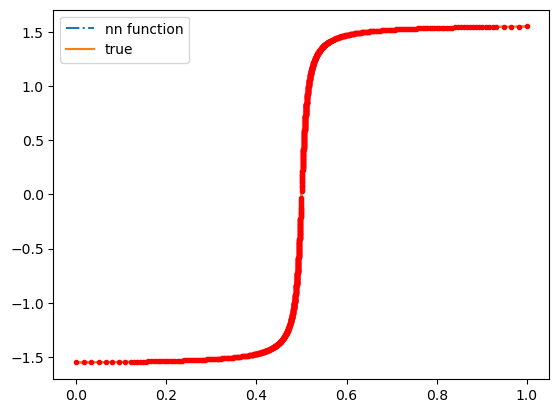

time taken:  248.44941210746765
neuron num 		 error 		 order
4 		 0.498657 		 * 		 9.886012 		 * 

8 		 0.051311 		 3.280711 		 3.019336 		 1.711158 

16 		 0.008188 		 2.647624 		 1.580821 		 0.933557 

32 		 0.002397 		 1.772637 		 0.754778 		 1.066550 

64 		 0.000559 		 2.098959 		 0.375524 		 1.007146 

128 		 0.000157 		 1.835646 		 0.185377 		 1.018442 

256 		 0.000039 		 1.988696 		 0.093976 		 0.980103 

512 		 0.000009 		 2.068645 		 0.047615 		 0.980881 

1024 		 0.000003 		 1.823751 		 0.022648 		 1.072056 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order & 	 $ | u -u_n |_{H^1}$ & 	 order \\ \hline \hline 
4 		 & 0.498657 &		 * & 		 9.886012 & 		 *  \\ \hline  

8 		 &  5.131e-02 &  		 3.28 &  		 3.019e+00 &  		 1.71 \\ \hline  

16 		 &  8.188e-03 &  		 2.65 &  		 1.581e+00 &  		 0.93 \\ \hline  

32 		 &  2.397e-03 &  		 1.77 &  		 7.548e-01 &  		 1.07 \\ \hline  

64 		 &  5.594e-04 &  		 2.10 &  		 3.755e-01 &  		 1.01 \\ \hline  

128 		 &  1.567e-04 &  		 1.84 &  		 1.8

In [11]:
## arctan example 
alpha = 100 
def u_exact(x):
    return torch.arctan(alpha * (x-0.5))

def du_exact(x):
    return alpha/(1+(alpha*(x-0.5))**2)
def laplace_u_exact(x):
    return -2*alpha**3*(x-0.5)/(1+(alpha*(x-0.5))**2)**2

def rhs(x):
    return  -laplace_u_exact(x) + u_exact(x)**3 

def g_N(x):
    return du_exact(x) 

function_name = "arctan1d" 
filename_write = "data/1DOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

save = False 

for N in [2**13]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 2**14
    order = 3  
    exponent = 10 
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
         
    err_QMC2, err_h10, my_model = CGANonlinearPoissonReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =1, solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_1D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    show_convergence_order(err_QMC2,err_h10,exponent,2*N,filename_write,True)
    show_convergence_order_latex(err_QMC2,err_h10,exponent)
    
#     neuron_nums = [2**j for j in range(2,exponent+1)]
#     err_list = [err_QMC2[i] for i in neuron_nums ]
#     err_list2 = [err_h10[i] for i in neuron_nums ] 
#     # f_write.write('M:{}, relu {} \n'.format(M,k))
#     f_write.write('randomized dictionary size: {}\n'.format(N))
#     f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
#     print("neuron num \t\t error \t\t order")
#     for i, item in enumerate(err_list):
#         if i == 0: 
#             # print(neuron_nums[i], end = "\t\t")
#             # print(item, end = "\t\t")
            
#             # print("*")
#             print("{} \t\t {:.6f} \t\t * \t\t {:.6f} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ) )   
#             f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
#         else: 
#             # print(neuron_nums[i], end = "\t\t")
#             # print(item, end = "\t\t") 
#             # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
#             print("{} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
#             f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
#     f_write.write("\n")
#     f_write.close()
    
